# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Результаты работы также должны появиться в базе данных, так как они будут переданы аналитикам компании. В результате вашей работы в базе должна быть информация от вас в двух таблицах (смотри задание в конце нотубука). Наличие информации о ваших результатах в первой таблице: student_results - блокирующее задание, без его выполнения за домашнее задание ставится 0.

Продуктивной и интересной вам работы!

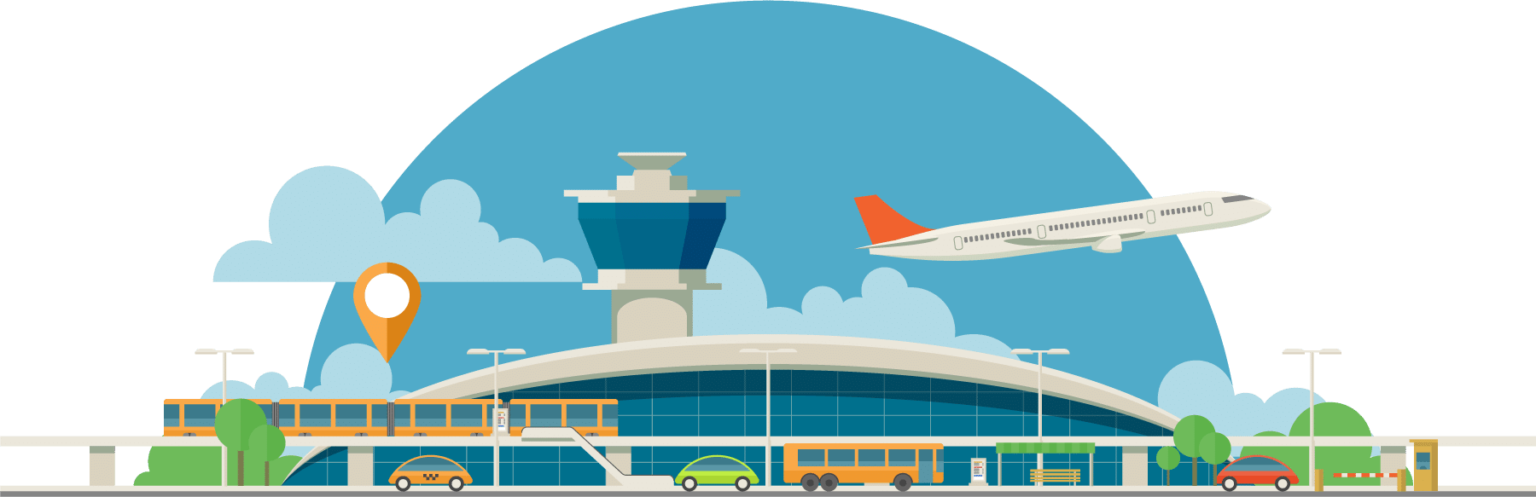

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода.

> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [2]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install eli5
!pip install missingno
!pip install psycopg2-binary
!pip install xgboost
!pip install lightgbm

  Using cached mlxtend-0.21.0-py2.py3-none-any.whl (1.3 MB)
  Using cached optuna-3.1.0-py3-none-any.whl (365 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
  Using cached alembic-1.9.2-py3-none-any.whl (210 kB)
  Using cached cmaes-0.9.1-py3-none-any.whl (21 kB)
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)
  Using cached lime-0.2.0.1-py3-none-any.whl
  Using cached shap-0.41.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (572 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
  Using cached eli5-0.13.0-py2.py3-none-any.whl
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import eli5
import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)


# Data Prep & EDA (2.5 балла + 0.25)

## Загрузка и предобработка данных (1.5 балла)

In [2]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-02-05 17:23:01--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3,5K) [application/x-x509-ca-cert]
Saving to: ‘/home/dinara/.postgresql/root.crt’

/home/dinara/.postg 100%[===================>]   3,50K  --.-KB/s    in 0s      

2023-02-05 17:23:01 (2,43 GB/s) - ‘/home/dinara/.postgresql/root.crt’ saved [3579/3579]



(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycog2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно.

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

### Схема БД

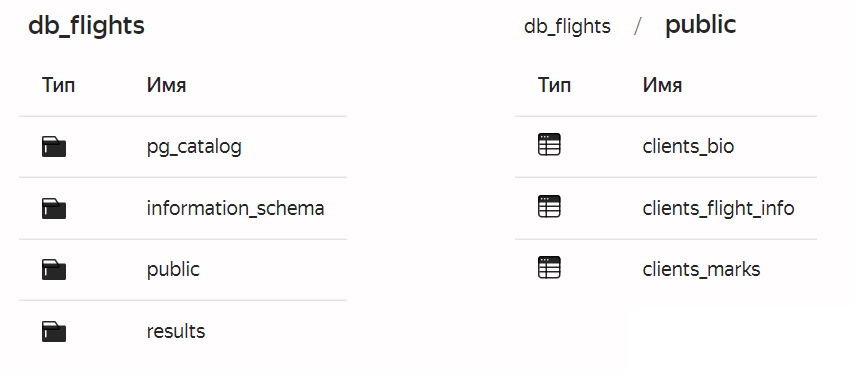

In [3]:
conn = psycopg2.connect(host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
                        port="6432",
                        sslmode="verify-full",
                        dbname="db_flights",
                        user="mlhs_student",
                        password="mlhs_student")

In [4]:
from contextlib import closing
with closing(psycopg2.connect(host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
                        port="6432",
                        sslmode="verify-full",
                        dbname="db_flights",
                        user="mlhs_student",
                        password="mlhs_student")) as conn:
    with conn.cursor() as cursor:
        print("table = clients_bio")
        cursor.execute("SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = N'clients_bio'")
        for row in cursor:
            print(row)
        print("table = clients_flight_info")
        cursor.execute("SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = N'clients_flight_info'")
        for row in cursor:
            print(row)
        print("table = clients_marks")
        cursor.execute("SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = N'clients_marks'")
        for row in cursor:
            print(row)

table = clients_bio
('id',)
('gender',)
('age',)
table = clients_flight_info
('id',)
('Customer Type',)
('Type of Travel',)
('class',)
('Flight Distance',)
('Departure Delay in Minutes',)
('Arrival Delay in Minutes',)
table = clients_marks
('id',)
('Inflight wifi service',)
('Departure/Arrival time convenient',)
('Ease of Online booking',)
('Gate location',)
('Food and drink',)
('Online boarding',)
('Seat comfort',)
('Inflight entertainment',)
('On-board service',)
('Leg room service',)
('Baggage handling',)
('Checkin service',)
('Inflight service',)
('cleanliness',)
('satisfaction',)


In [6]:
def sql_to_dataframe(conn, query, column_names):
    """
    Import data from a PostgreSQL database using a SELECT query
    """
    cursor = conn.cursor()
    try:
        cursor.execute(query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    # The execute returns a list of tuples:
    tuples_list = cursor.fetchall()
    cursor.close()
    # Now we need to transform the list into a pandas DataFrame:
    df = pd.DataFrame(tuples_list, columns=column_names)
    return df
#источник https://medium.com/@alestamm/importing-data-from-a-postgresql-database-to-a-pandas-dataframe-5f4bffcd8bb2

In [7]:
column_names = ["id",
    "gender",
    "age",
    "Customer Type",
    "Type of Travel",
    "class",
    "Flight Distance",
    "Departure Delay in Minutes",
    "Arrival Delay in Minutes",
    "Inflight wifi service",
    "Departure/Arrival time convenient",
    "Ease of Online booking",
    "Gate location",
    "Food and drink",
    "Online boarding",
    "Seat comfort",
    "Inflight entertainment",
    "On-board service",
    "Leg room service",
    "Baggage handling",
    "Checkin service",
    "Inflight service",
    "cleanliness",
    "satisfaction"]
with closing(psycopg2.connect(host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
                        port="6432",
                        sslmode="verify-full",
                        dbname="db_flights",
                        user="mlhs_student",
                        password="mlhs_student")) as conn:
    query = 'SELECT clients_bio.id, clients_bio.gender, clients_bio.age,\
        clients_flight_info."Customer Type", clients_flight_info."Type of Travel",\
        clients_flight_info.class, clients_flight_info."Flight Distance",\
        clients_flight_info."Departure Delay in Minutes", clients_flight_info."Arrival Delay in Minutes",\
        clients_marks."Inflight wifi service", clients_marks."Departure/Arrival time convenient",\
        clients_marks."Ease of Online booking", clients_marks."Gate location",\
        clients_marks."Food and drink", clients_marks."Online boarding",\
        clients_marks."Seat comfort", clients_marks."Inflight entertainment",\
        clients_marks."On-board service", clients_marks."Leg room service",\
        clients_marks."Baggage handling", clients_marks."Checkin service",\
        clients_marks."Inflight service", clients_marks.cleanliness,\
                       clients_marks.satisfaction\
                       FROM clients_bio\
                       INNER JOIN clients_flight_info ON clients_flight_info.id=clients_bio.id\
                       INNER JOIN clients_marks ON clients_marks.id=clients_bio.id;'
    df = sql_to_dataframe(conn, query, column_names)
df.head()

id  gender   age      Customer Type   Type of Travel     class  \
0   7    Male  43.0     Loyal Customer  Business travel  Business   
1  13    Male  24.0  disloyal Customer  Business travel       Eco   
2  18  Female  61.0     Loyal Customer  Personal Travel       Eco   
3  31    Male  35.0  disloyal Customer  Business travel  Business   
4  39  Female  46.0     Loyal Customer  Business travel  Business   

  Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
0          1963.0                        0.0                      0.0   
1           453.0                       16.0                     30.0   
2           821.0                        0.0                      0.0   
3           212.0                        0.0                      0.0   
4            67.0                        0.0                      0.0   

  Inflight wifi service  ... Online boarding Seat comfort  \
0                   3.0  ...             4.0          5.0   
1                   2.0  ...             2.0          5.0   
2                   2.0  ...             1.0          5.0   
3                   2.0  ...             2.0          2.0   
4                   3.0  ...             5.0          4.0   

  Inflight entertainment On-board service Leg room service Baggage handling  \
0                    5.0              5.0              5.0              5.0   
1                    5.0              2.0              4.0              4.0   
2                    5.0              5.0              2.0              5.0   
3                    2.0              4.0              5.0              5.0   
4                    4.0              4.0              4.0              4.0   

  Checkin service Inflight service cleanliness             satisfaction  
0             4.0              5.0         4.0                satisfied  
1             2.0              4.0         5.0  neutral or dissatisfied  
2             5.0              5.0         1.0  neutral or dissatisfied  
3             5.0              4.0         2.0  neutral or dissatisfied  
4             5.0              4.0         5.0                satisfied  

[5 rows x 24 columns]

In [8]:
df = df.set_index('id')
df = df.sort_index()
df.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
1     Male  48.0  disloyal Customer  Business travel  Business   
2   Female  35.0     Loyal Customer  Business travel  Business   
3     Male  41.0     Loyal Customer  Business travel  Business   
4     Male  50.0     Loyal Customer  Business travel  Business   
5   Female  49.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
1            821.0                        2.0                      5.0   
2            821.0                       26.0                     39.0   
3            853.0                        0.0                      0.0   
4           1905.0                        0.0                      0.0   
5           3470.0                        0.0                      1.0   

   Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                          ...   
1                    3.0                               3.0  ...   
2                    2.0                               2.0  ...   
3                    4.0                               4.0  ...   
4                    2.0                               2.0  ...   
5                    3.0                               3.0  ...   

   Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                        
1              3.0          5.0                    5.0              3.0   
2              5.0          4.0                    5.0              5.0   
3              5.0          5.0                    3.0              3.0   
4              4.0          5.0                    5.0              5.0   
5              5.0          4.0                    3.0              3.0   

   Leg room service Baggage handling Checkin service Inflight service  \
id                                                                      
1               2.0              5.0             4.0              5.0   
2               5.0              5.0             3.0              5.0   
3               3.0              3.0             4.0              3.0   
4               5.0              5.0             3.0              5.0   
5               4.0              3.0             3.0              3.0   

   cleanliness             satisfaction  
id                                       
1          5.0  neutral or dissatisfied  
2          5.0                satisfied  
3          5.0                satisfied  
4          4.0                satisfied  
5          5.0                satisfied  

[5 rows x 23 columns]

In [ ]:
df.to_csv('flights.csv')

In [2]:
df = pd.read_csv('flights.csv')
df = df.set_index('id')
df = df.sort_index()
df.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
1     Male  48.0  disloyal Customer  Business travel  Business   
2   Female  35.0     Loyal Customer  Business travel  Business   
3     Male  41.0     Loyal Customer  Business travel  Business   
4     Male  50.0     Loyal Customer  Business travel  Business   
5   Female  49.0     Loyal Customer  Business travel  Business   

    Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                          
1             821.0                         2.0                       5.0   
2             821.0                        26.0                      39.0   
3             853.0                         0.0                       0.0   
4            1905.0                         0.0                       0.0   
5            3470.0                         0.0                       1.0   

    Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                            ...   
1                     3.0                                3.0  ...   
2                     2.0                                2.0  ...   
3                     4.0                                4.0  ...   
4                     2.0                                2.0  ...   
5                     3.0                                3.0  ...   

    Online boarding  Seat comfort  Inflight entertainment  On-board service  \
id                                                                            
1               3.0           5.0                     5.0               3.0   
2               5.0           4.0                     5.0               5.0   
3               5.0           5.0                     3.0               3.0   
4               4.0           5.0                     5.0               5.0   
5               5.0           4.0                     3.0               3.0   

    Leg room service  Baggage handling  Checkin service  Inflight service  \
id                                                                          
1                2.0               5.0              4.0               5.0   
2                5.0               5.0              3.0               5.0   
3                3.0               3.0              4.0               3.0   
4                5.0               5.0              3.0               5.0   
5                4.0               3.0              3.0               3.0   

    cleanliness             satisfaction  
id                                        
1           5.0  neutral or dissatisfied  
2           5.0                satisfied  
3           5.0                satisfied  
4           4.0                satisfied  
5           5.0                satisfied  

[5 rows x 23 columns]

In [4]:
assert df.shape == (129549, 23)

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129549 entries, 1 to 129880
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129472 non-null  object 
 3   Type of Travel                     129448 non-null  object 
 4   class                              129433 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      1295

In [5]:
df.dtypes

gender                                object
age                                  float64
Customer Type                         object
Type of Travel                        object
class                                 object
Flight Distance                      float64
Departure Delay in Minutes           float64
Arrival Delay in Minutes             float64
Inflight wifi service                float64
Departure/Arrival time convenient    float64
Ease of Online booking               float64
Gate location                        float64
Food and drink                       float64
Online boarding                      float64
Seat comfort                         float64
Inflight entertainment               float64
On-board service                     float64
Leg room service                     float64
Baggage handling                     float64
Checkin service                      float64
Inflight service                     float64
cleanliness                          float64
satisfacti

In [13]:
df.isna().sum()

gender                                 0
age                                  315
Customer Type                         77
Type of Travel                       101
class                                116
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             107
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64

(0.25 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

<AxesSubplot:>

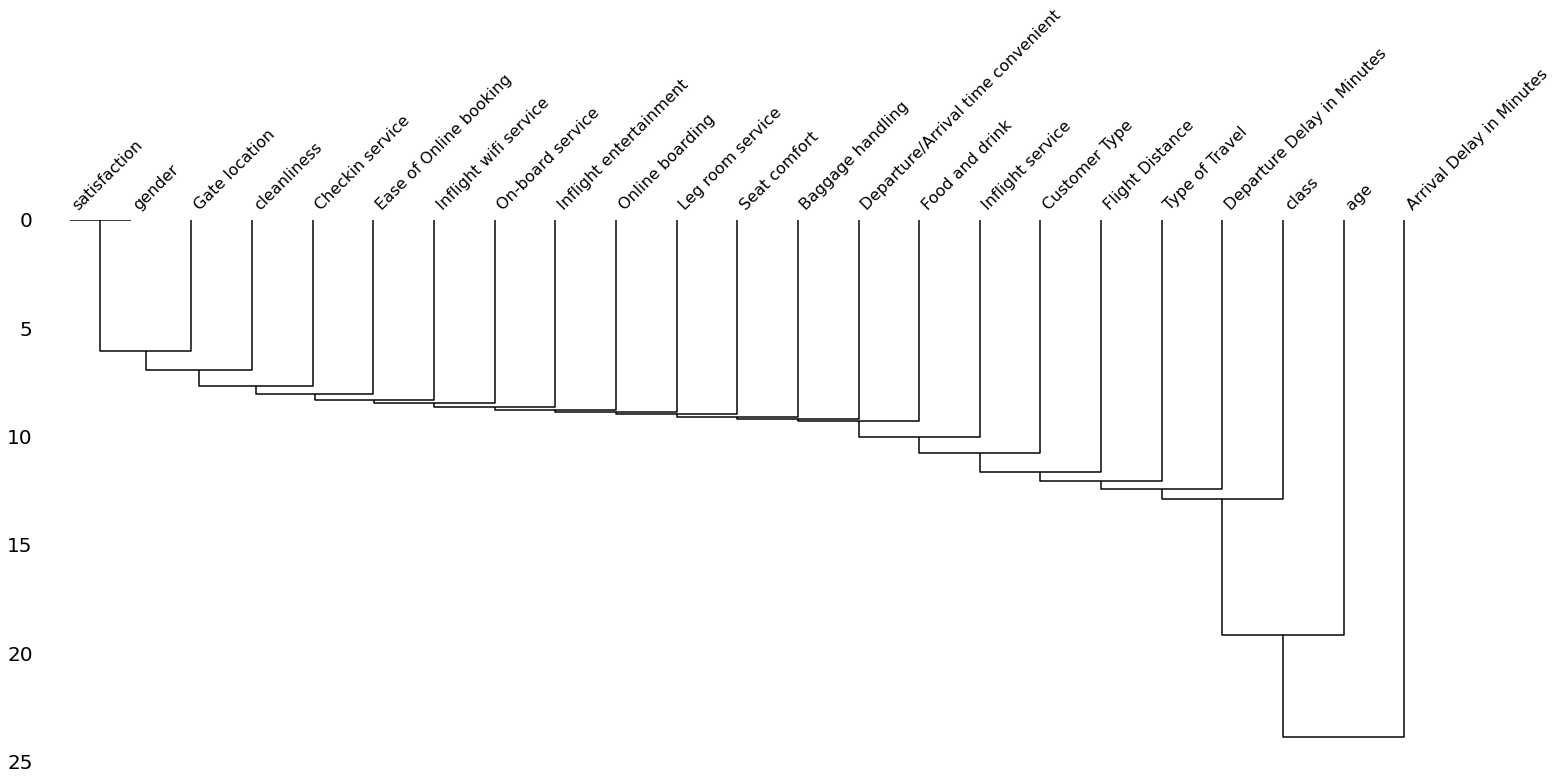

In [87]:
msno.dendrogram(df)
#источник https://www.kaggle.com/code/selahattinsanli/visualizing-missing-data

<AxesSubplot:>

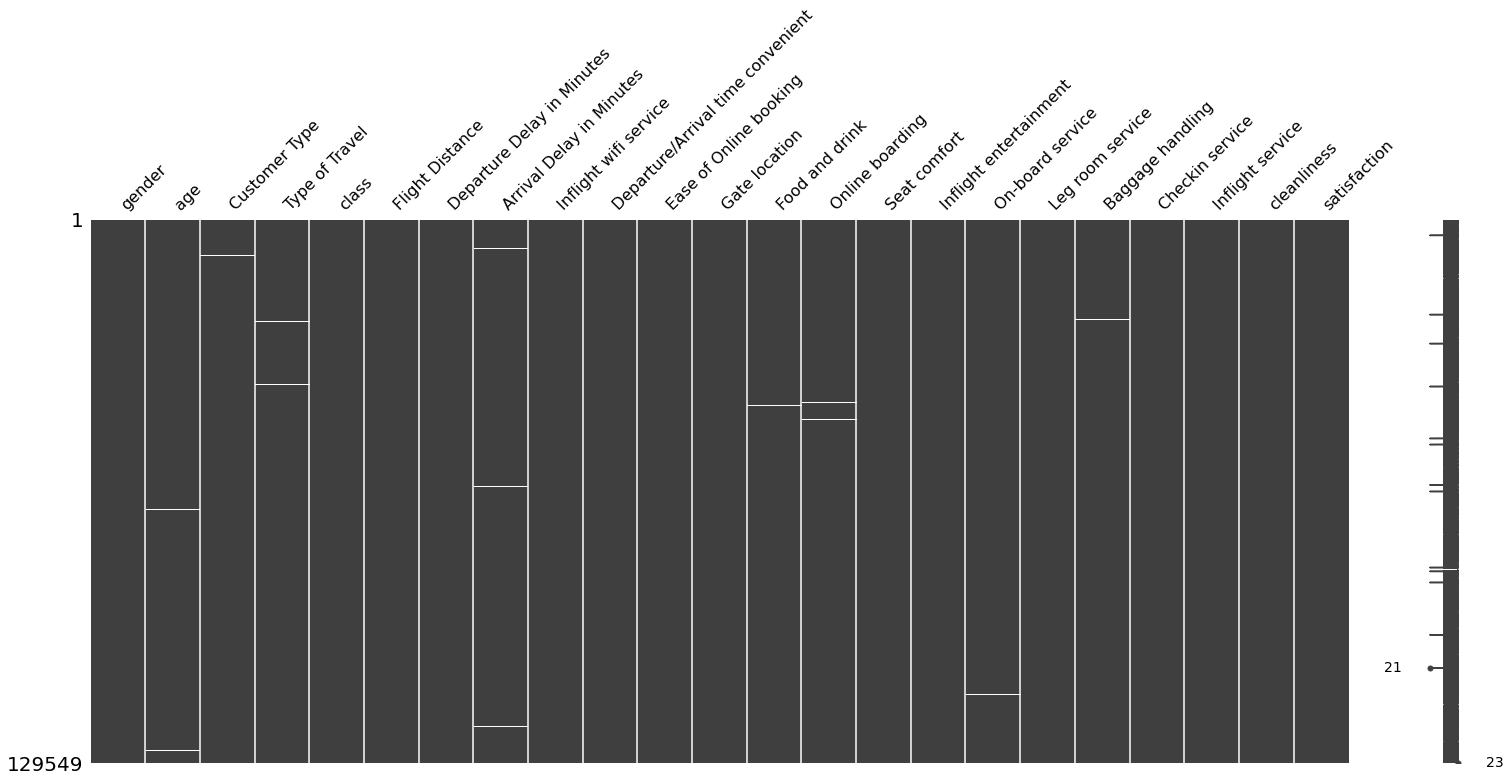

In [88]:
msno.matrix(df)

FixedFormatter should only be used together with FixedLocator


<AxesSubplot:>

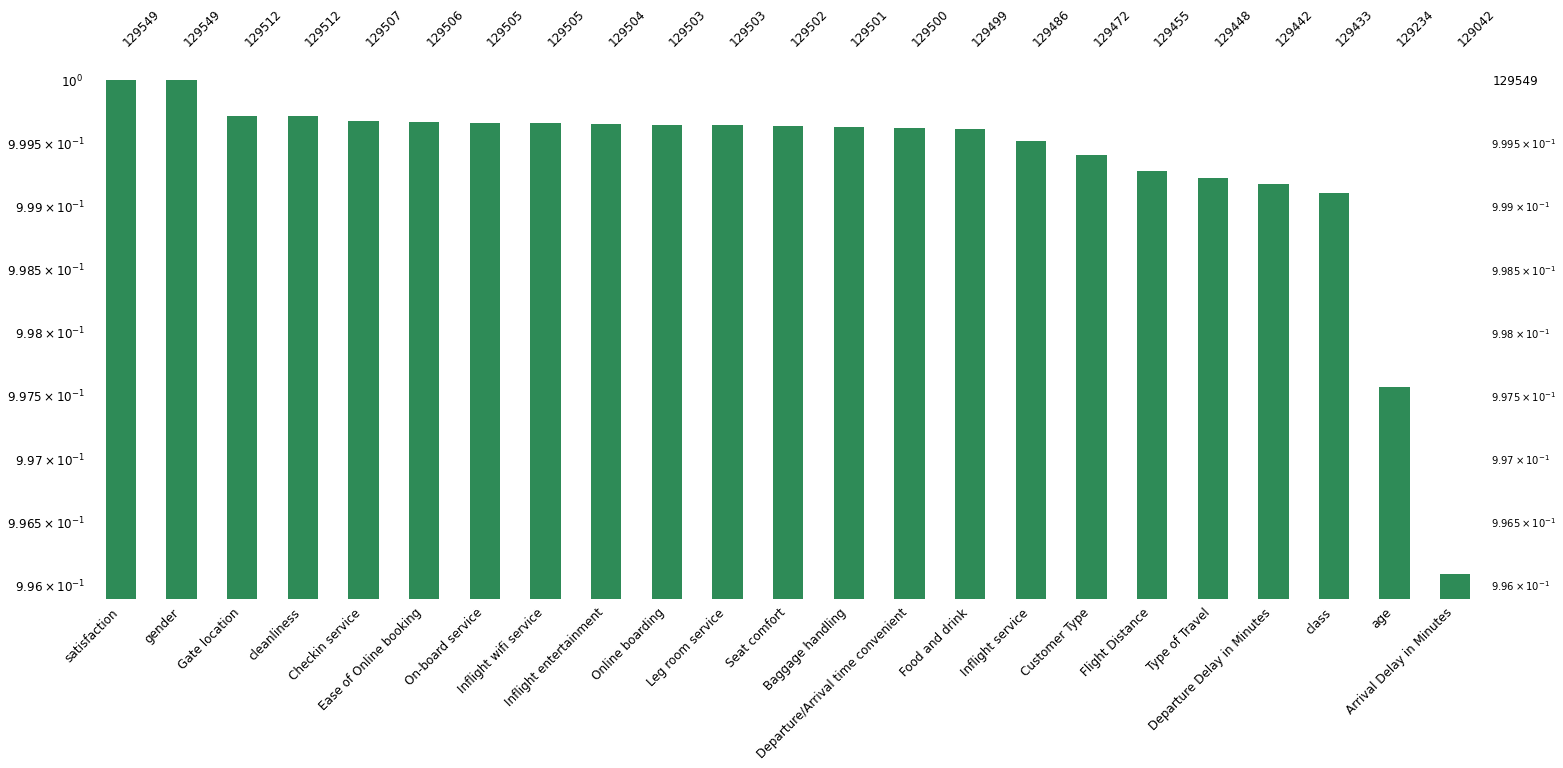

In [89]:
msno.bar(df, fontsize=12, color="seagreen", log=True, sort="descending")

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [4]:
df_train = df[df.satisfaction != '-']
df_train.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
1     Male  48.0  disloyal Customer  Business travel  Business   
2   Female  35.0     Loyal Customer  Business travel  Business   
3     Male  41.0     Loyal Customer  Business travel  Business   
4     Male  50.0     Loyal Customer  Business travel  Business   
5   Female  49.0     Loyal Customer  Business travel  Business   

    Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                          
1             821.0                         2.0                       5.0   
2             821.0                        26.0                      39.0   
3             853.0                         0.0                       0.0   
4            1905.0                         0.0                       0.0   
5            3470.0                         0.0                       1.0   

    Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                            ...   
1                     3.0                                3.0  ...   
2                     2.0                                2.0  ...   
3                     4.0                                4.0  ...   
4                     2.0                                2.0  ...   
5                     3.0                                3.0  ...   

    Online boarding  Seat comfort  Inflight entertainment  On-board service  \
id                                                                            
1               3.0           5.0                     5.0               3.0   
2               5.0           4.0                     5.0               5.0   
3               5.0           5.0                     3.0               3.0   
4               4.0           5.0                     5.0               5.0   
5               5.0           4.0                     3.0               3.0   

    Leg room service  Baggage handling  Checkin service  Inflight service  \
id                                                                          
1                2.0               5.0              4.0               5.0   
2                5.0               5.0              3.0               5.0   
3                3.0               3.0              4.0               3.0   
4                5.0               5.0              3.0               5.0   
5                4.0               3.0              3.0               3.0   

    cleanliness             satisfaction  
id                                        
1           5.0  neutral or dissatisfied  
2           5.0                satisfied  
3           5.0                satisfied  
4           4.0                satisfied  
5           5.0                satisfied  

[5 rows x 23 columns]

In [5]:
assert df_train.shape == (103_644, 23)

In [6]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
17  Female  48.0     Loyal Customer  Personal Travel       Eco   
20  Female  42.0     Loyal Customer  Personal Travel       Eco   
35    Male  39.0     Loyal Customer  Business travel  Business   
44    Male  51.0     Loyal Customer  Business travel  Business   
49    Male  20.0  disloyal Customer  Business travel       Eco   

    Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                          
17            821.0                         0.0                       0.0   
20            821.0                         4.0                       0.0   
35           1672.0                        23.0                      17.0   
44           2077.0                         0.0                       1.0   
49            108.0                         0.0                      29.0   

    Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                            ...   
17                    2.0                                3.0  ...   
20                    3.0                                3.0  ...   
35                    2.0                                2.0  ...   
44                    4.0                                1.0  ...   
49                    4.0                                5.0  ...   

    Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                          
17             1.0              5.0           1.0                     5.0   
20             1.0              3.0           4.0                     1.0   
35             5.0              4.0           5.0                     3.0   
44             2.0              5.0           5.0                     5.0   
49             5.0              4.0           3.0                     5.0   

    On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                          
17               5.0               2.0               5.0              5.0   
20               1.0               3.0               1.0              3.0   
35               3.0               4.0               5.0              5.0   
44               5.0               5.0               5.0              5.0   
49               5.0               4.0               5.0              5.0   

    Inflight service  cleanliness  
id                                 
17               5.0          2.0  
20               1.0          3.0  
35               3.0          5.0  
44               5.0          4.0  
49               4.0          5.0  

[5 rows x 22 columns]

In [7]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [8]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [9]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

X_train.columns(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые.

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [10]:
from sklearn import impute


# заполним пропуски модами в X_train
mis_replacer = impute.SimpleImputer(strategy="most_frequent")
mis_replacer.fit(X_train)
X_train = pd.DataFrame(data=mis_replacer.transform(X_train), columns=X_train.columns, index=X_train.index)


# заполним пропуски модами в X_val
X_val = pd.DataFrame(data=mis_replacer.transform(X_val), columns=X_val.columns, index=X_val.index)


# заполним пропуски модами в df_test
df_test = pd.DataFrame(data=mis_replacer.transform(df_test), columns=df_test.columns, index=df_test.index)

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [7]:
X_train.describe()

gender      age   Customer Type   Type of Travel     class  \
count    72550  72550.0           72550            72550     72550   
unique       2    218.0               2                2         3   
top     Female     39.0  Loyal Customer  Business travel  Business   
freq     36738   2257.0           59364            50046     34639   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
count           72550.0                     72550.0                   72550.0   
unique           3888.0                       432.0                     451.0   
top               337.0                         0.0                       0.0   
freq              484.0                     40979.0                   40834.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
count                 72550.0                            72550.0  ...   
unique                   15.0                               19.0  ...   
top                       3.0                                4.0  ...   
freq                  18092.0                            17945.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
count          72550.0          72550.0       72550.0                 72550.0   
unique            17.0             20.0          19.0                    17.0   
top                4.0              4.0           4.0                     4.0   
freq           17087.0          21560.0       22220.0                 20540.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
count            72550.0           72550.0           72550.0          72550.0   
unique              18.0              22.0              19.0             21.0   
top                  4.0               4.0               4.0              4.0   
freq             21495.0           20096.0           25953.0          20400.0   

        Inflight service  cleanliness  
count            72550.0      72550.0  
unique              21.0         18.0  
top                  4.0          4.0  
freq             26435.0      18959.0  

[4 rows x 22 columns]

In [11]:
# для удобства работы с нашим датасетом создаем маску, указывающую на столбцы с категориальными признаками
cat_features_mask_train = (df_train.dtypes == "object").values # категориальные признаки имеют тип "object"
num_features = list(df_train[df_train.columns[~cat_features_mask_train]].columns)
for i in num_features:
    X_train[i] = X_train[i].astype('float')
    X_val[i] = X_val[i].astype('float')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72550 entries, 32806 to 19805
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             72550 non-null  object 
 1   age                                72550 non-null  float64
 2   Customer Type                      72550 non-null  object 
 3   Type of Travel                     72550 non-null  object 
 4   class                              72550 non-null  object 
 5   Flight Distance                    72550 non-null  float64
 6   Departure Delay in Minutes         72550 non-null  float64
 7   Arrival Delay in Minutes           72550 non-null  float64
 8   Inflight wifi service              72550 non-null  float64
 9   Departure/Arrival time convenient  72550 non-null  float64
 10  Ease of Online booking             72550 non-null  float64
 11  Gate location                      72550 non-null 

In [10]:
X_train[X_train['age'] == 612]

gender    age   Customer Type   Type of Travel class  Flight Distance  \
id                                                                             
58437  Female  612.0  Loyal Customer  Personal Travel   Eco            473.0   

       Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                            
58437                         0.0                       0.0   

       Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                               ...   
58437                    1.0                                3.0  ...   

       Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                             
58437             5.0              4.0           3.0                     3.0   

       On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                             
58437               3.0               1.0               3.0              3.0   

       Inflight service  cleanliness  
id                                    
58437               3.0          2.0  

[1 rows x 22 columns]

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

🐡 Сразу заметны выбросы в данных о возрасте, которые надо удалить. В основном, по таблице выше со статистикой об X_train можно сказать, что выбросы есть почти во всех столбцах, кроме данных категориальных, т.е. 'age', 'Flight Distance' и т.д.
Для столбца 'Flight Distance' макисмальное значение 328510 является выбросом и в столбце о возрасте 612 - тоже выброс.

(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах.</font> Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [12]:
num_features = list(df_train[df_train.columns[~cat_features_mask_train]].columns)
data_outliers = {}
#находим значения квантиля для всех числовых признаков в X_train
for i in num_features:
    data_outliers[i] = np.quantile(X_train[i], 0.996)
#удаляем выбросы из X_train
for i in data_outliers.keys():
    X_train = X_train[X_train[i] <= data_outliers[i]]
#находим значения квантиля для всех числовых признаков в X_val
for i in data_outliers.keys():
    data_outliers[i] = np.quantile(X_val[i], 0.996)
#удаляем выбросы из X_val
for i in data_outliers:
    X_val = X_val[X_val[i] <= data_outliers[i]]  

In [13]:
y_train = y_train[y_train.index.isin(X_train.index)]
y_val = y_val[y_val.index.isin(X_val.index)]

In [14]:
assert X_train.shape == (71_369, 22)
assert X_val.shape == (30_609, 22)
assert df_test.shape == (25_905, 22)

## EDA (1 балл + 0.25)

Создадим переменные с перечислениями столбцов разного типа

In [15]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [15]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [16]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(18, 18))
    j = 0
    for i in cols:
        sns.countplot(x=df[i], hue=y, ax=axes.flatten()[j])
        #sns.countplot(x=df[i], ax=axes.flatten()[j])
        axes.flatten()[j].set_title('Для порядкового признака '+ i + ' распределение данных по классам')
        fig.tight_layout()
        j += 1
    plt.show()
    pass


In [17]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 18), sharey='none', sharex='none')
    j = 0
    for i in cols:
        sns.kdeplot(data=df, x = i, hue=y, ax=axes.flatten()[2 * j])
        sns.boxplot(data=df, y=df[i], x = y, ax=axes.flatten()[2 * j + 1])
        axes.flatten()[j].set_title('Для континуального признака '+ i + ' распределение данных')
        fig.tight_layout()
        j += 1
    plt.show()
    pass

In [18]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 18))
    j = 0
    for i in cols:
        sns.countplot(x=df[i], hue=y, ax=axes.flatten()[j])
        axes.flatten()[j].set_title('Для категориального признака '+ i + ' распределение данных по категориям')
        fig.tight_layout()
        j += 1
    plt.show()
    pass

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

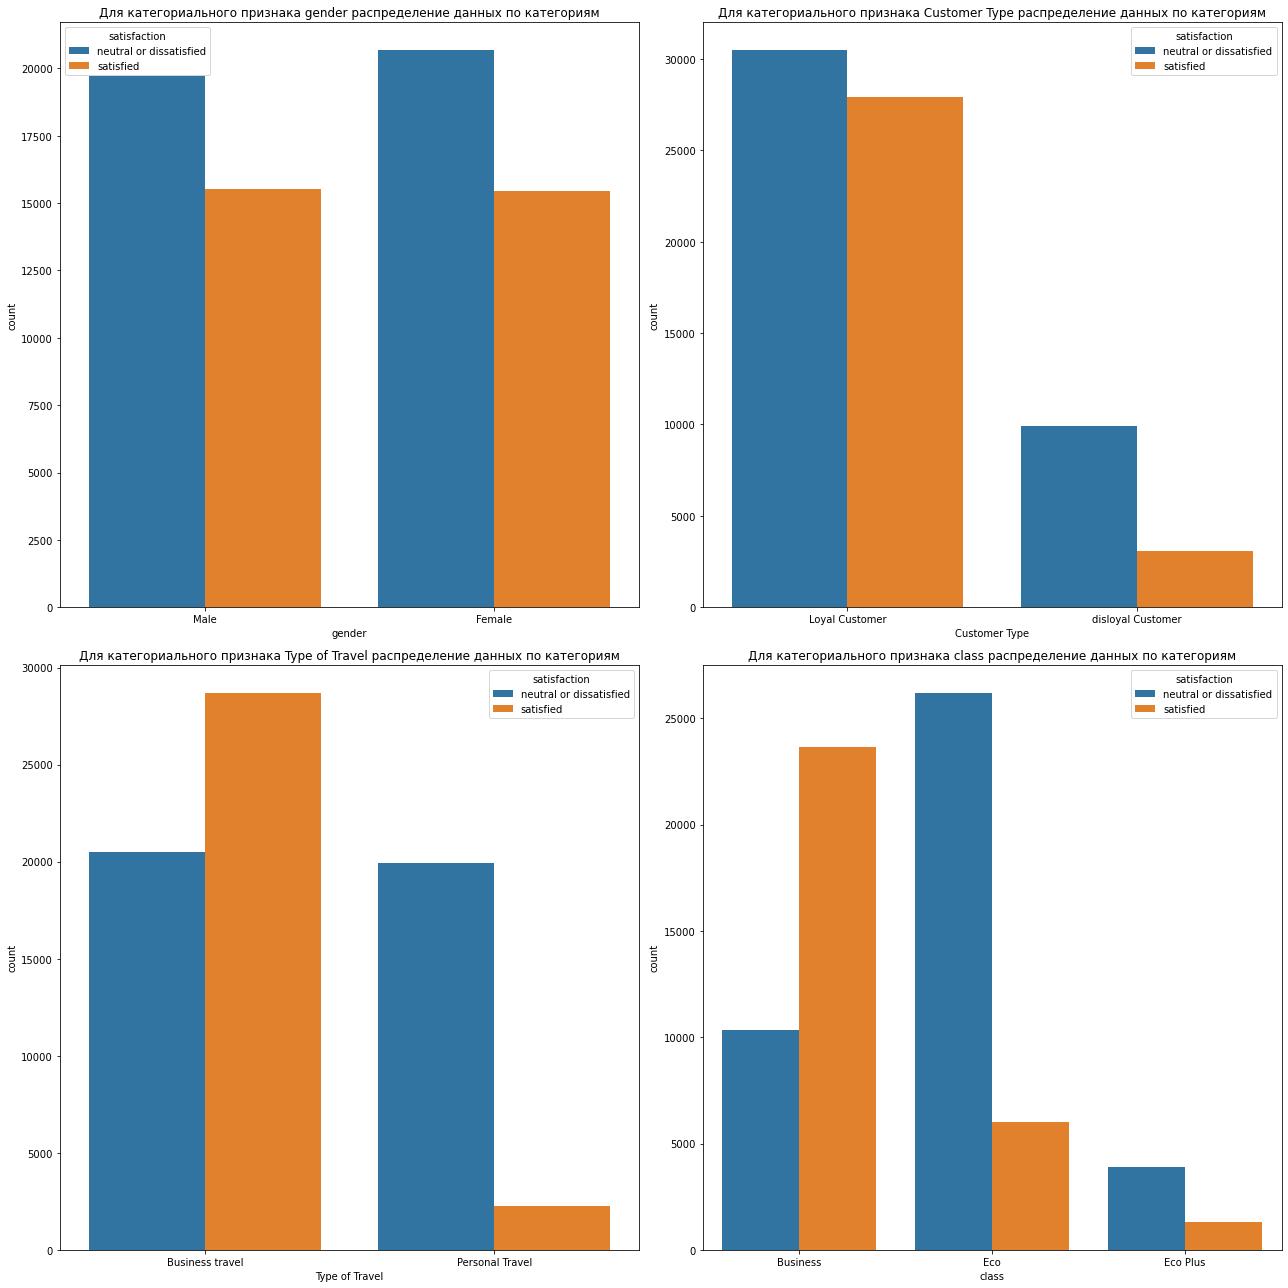

In [110]:
plot_categorical(categorical_cols, X_train, y_train)

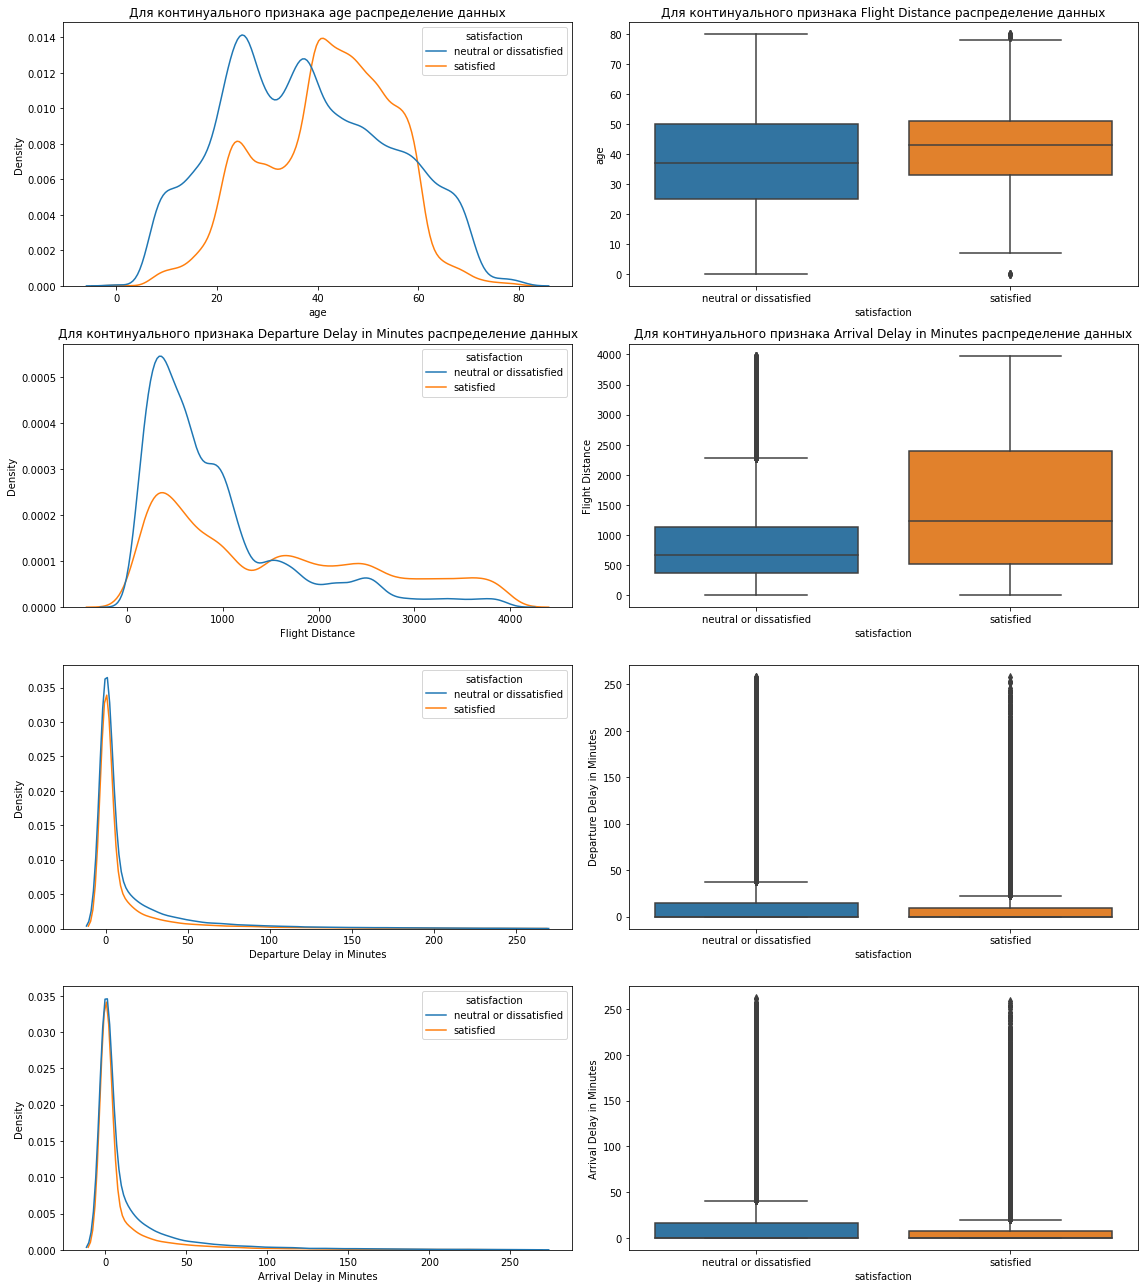

In [111]:
plot_continuous(continuous_cols, X_train, y_train)

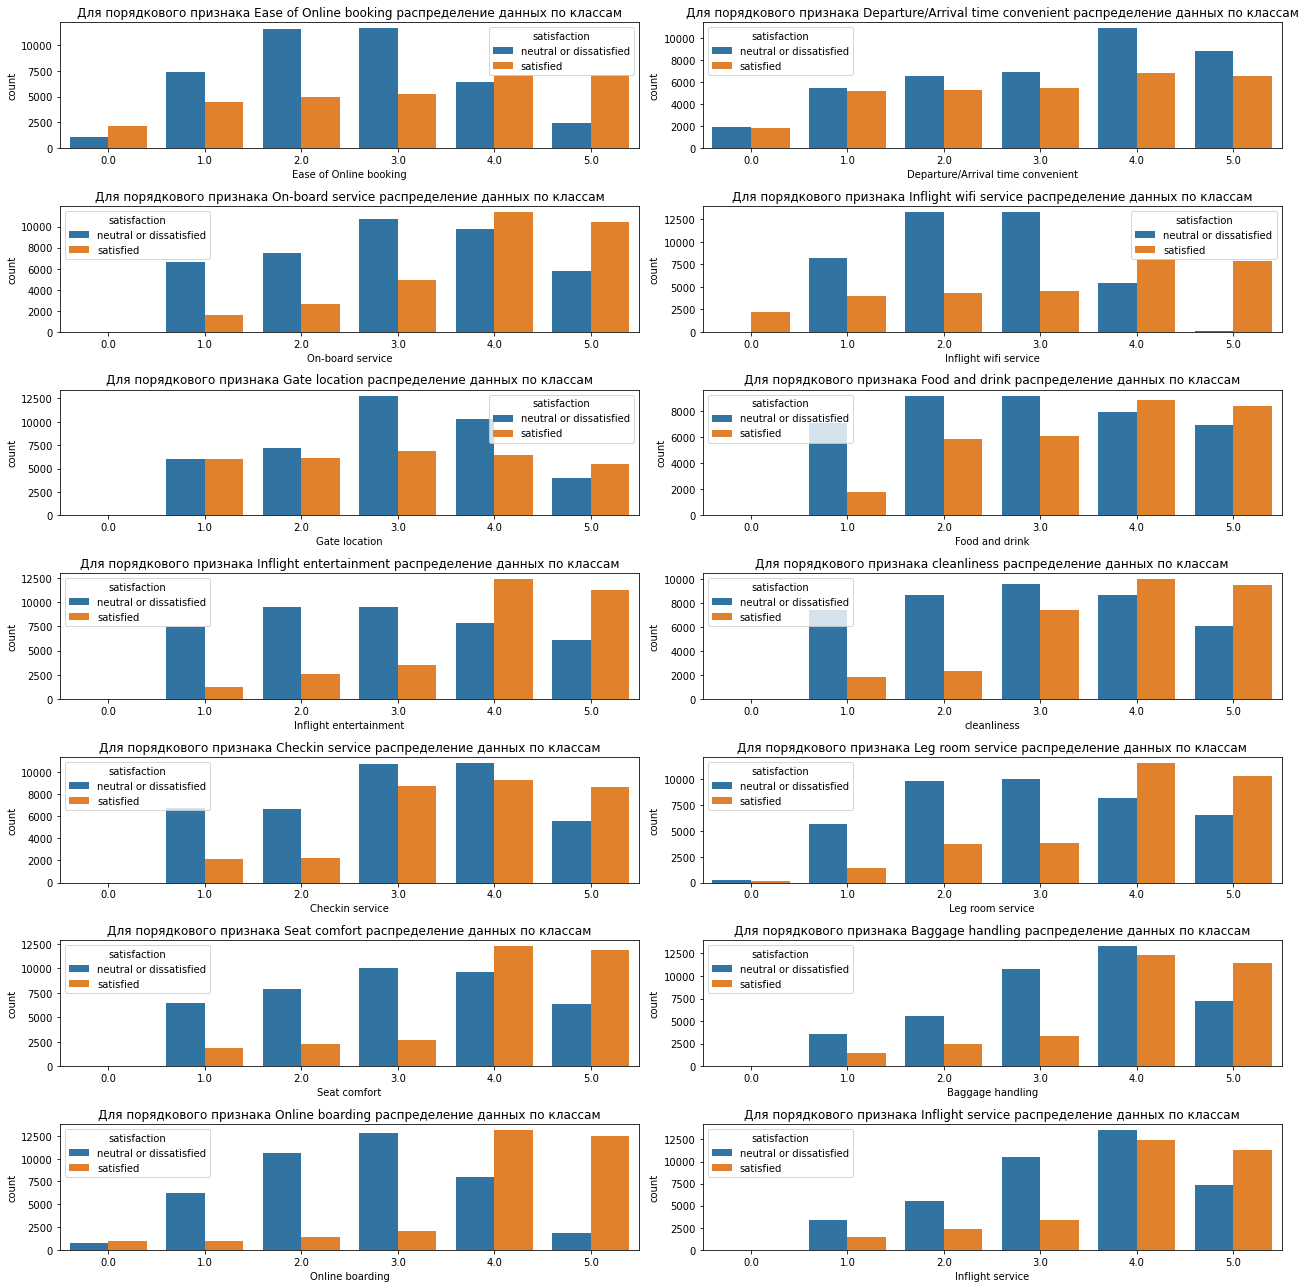

In [112]:
plot_ordinal(ordinal_cols, X_train, y_train)

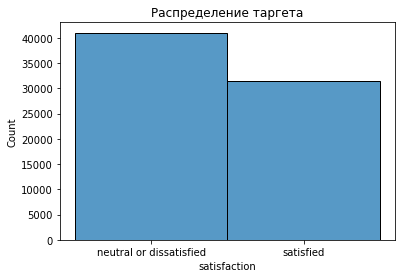

In [113]:
# visualize y_train
sns.histplot(y_train).set_title('Распределение таргета');

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

In [ ]:
# your answer here
# feel free to change this cell from code to markdown
🐢 Для категориальных признаков:
     по полу данные сбалансированы, таргет для обоих категорий почти одинаковый, можно предположить,
    что пол почти не влияет на таргет;
    - по типу клиента видно, что лояльных больше, но распределение среди них с положительной и нейтральной/отрицательной оценками
    сервисов полета почти одинаков, хотя заметно, что распределение таргета среди нелояльных больше указывает на то,
    что их оценка будет с большей вероятностью нейтральной/отрицательной;
    - по типу поездки наблюдается заметный перевес положительной оценки для бизнеса,
    а для персональных поездок явный перевес - нейтральной/отрицательной;
    - по классу видно, что бизнес класса большинство клиентов оценивают положительно,
    а вот эко и эко+ придерживаются другого мнения о сервисе, видимо связано это с экологическими ограничениями:
    подавляющая часть оценивает нейтрально/отрицательно.

🐢 Для порядковых признаков:
    - для большинства признаков классы несбаласированы;
    - почти для всех признаков 0-й класс сильно отличается от других;
    - равномерное распределение классов заметна в признаках
        'food & drink' (скорее всего это связано с пищевыми предпочтениями разных людей,
    что, подозреваю, является равномерно распределенной случайной величиной),
        'Ease of Online booking' (здесь наверное с корректной работой веб платформы или с перебоями в сети,
    что тоже свидетельствует о равномерной распределенности указанных случ. величин),
        'Gate location' (неплохая сбалансированность связана, как мне кажется, с разным представлением людей об оптимальном месторасположении объектов),
        'Departure/Arrival time convenient' (аналогично удобство понятие относительное, поэтому сбалансированность обоснована этим);
    - исключая признаки перечисленные в пункте выше, можно заметить, что распределение таргета в классах 1.0-3.0 и 4.0-5.0 показывают явный перевес
    нейтральной/отрицательной оценки в первом сегменте и положительной - во втором;
    - для признаков 'food & drink', 'Ease of Online booking', 'Gate location' и 'Departure/Arrival time convenient' распределение таргета почти равномерно;
    - среди признаков 'seat comfort', 'online boarding', 'cleanliness', 'food & drink', 'leg room service', 'Baggage handling', 'Inflight entertainment', 'On-board service',
    'Checkin service' и 'Departure/Arrival time convenient' наиболее популярным ответом является оценка 4.0.

🐢 Для континуальных признаков:
    - для признака возраста распределение нормальное;
    - для признака 'Flight Distance' заметно, что положительные оценки распределены почти равномерно, а для нейтрально/отрицательного значения таргета
    наблюдается нормальное распределение со смещенным мат ожиданием;
    - для признаков 'Departure Delay in Minutes' и 'Arrival Delay in Minutes' графики плотности распределения свидетельствуют о нормальном распредлении данных.

(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

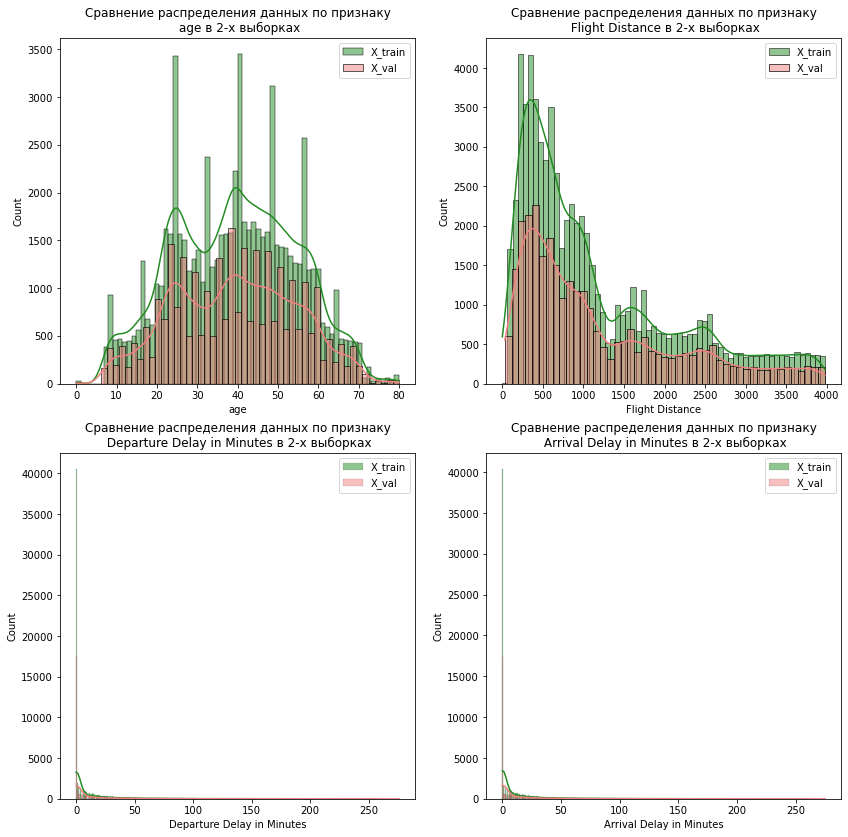

In [17]:
n_rows = len(continuous_cols)
f, ax = plt.subplots(2, 2, figsize=(14, 14))
for i in range(n_rows):
    if i % 2 == 0:
        j = 0
    else: j = 1
    sns.histplot(X_train[continuous_cols[i]], kde=True, label = 'X_train', ax=ax[int(i / 2)][j], color='forestgreen');
    sns.histplot(X_val[continuous_cols[i]], kde=True, label = 'X_val',ax=ax[int(i / 2)][j], color='lightcoral').set_title(f"Сравнение распределения данных по признаку\n {continuous_cols[i]} в 2-х выборках");
    ax[int(i / 2)][j].legend();

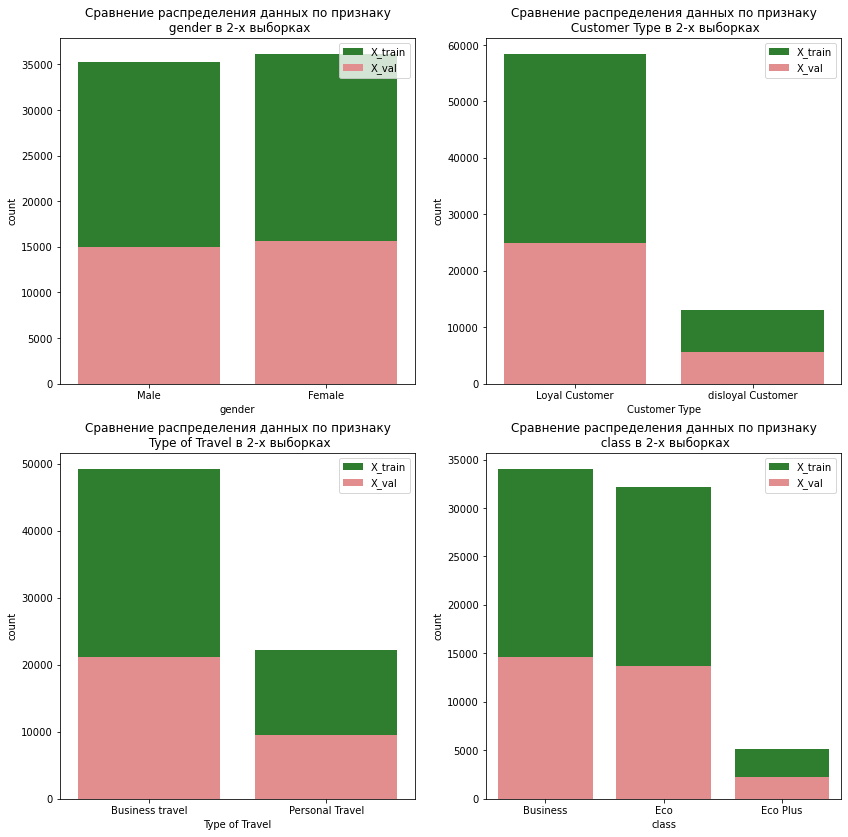

In [116]:
n_rows = len(categorical_cols)
f, ax = plt.subplots(2, 2, figsize=(14, 14))
for i in range(n_rows):
    if i % 2 == 0:
        j = 0
    else: j = 1
    sns.countplot(x=X_train[categorical_cols[i]], label = 'X_train', ax=ax[int(i / 2)][j], color='forestgreen');
    sns.countplot(x=X_val[categorical_cols[i]], label = 'X_val',ax=ax[int(i / 2)][j], color='lightcoral').set_title(f"Сравнение распределения данных по признаку\n {categorical_cols[i]} в 2-х выборках");
    ax[int(i / 2)][j].legend();

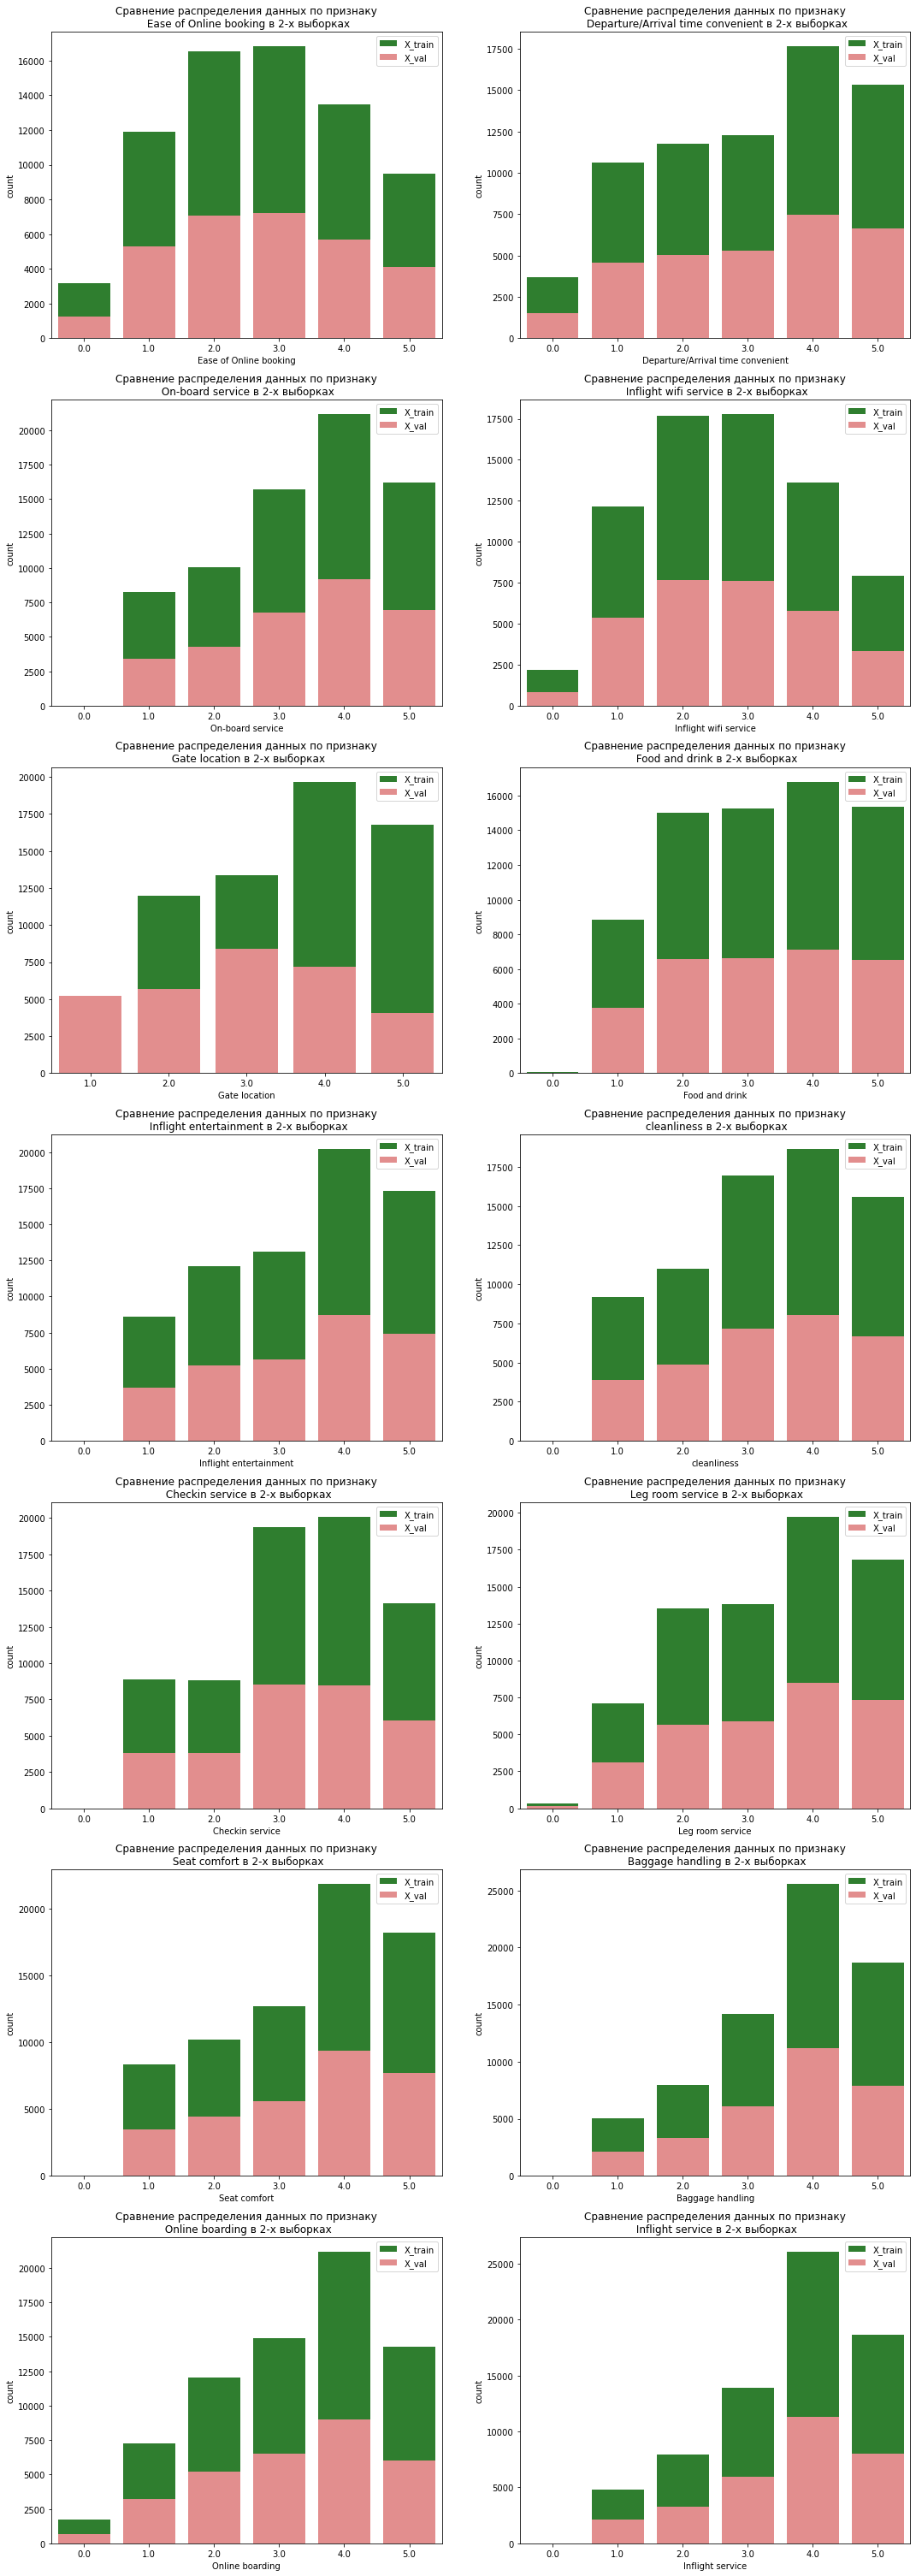

In [117]:
n_rows = len(ordinal_cols)
f, ax = plt.subplots(7, 2, figsize=(18, 54))
for i in range(n_rows):
    if i % 2 == 0:
        j = 0
    else: j = 1
    sns.countplot(x=X_train[ordinal_cols[i]], label = 'X_train', ax=ax[int(i / 2)][j], color='forestgreen');
    sns.countplot(x=X_val[ordinal_cols[i]], label = 'X_val',ax=ax[int(i / 2)][j], color='lightcoral').set_title(f"Сравнение распределения данных по признаку\n {ordinal_cols[i]} в 2-х выборках");
    ax[int(i / 2)][j].legend();

🦜Согласно визуальному исследованию построенных графиков, можно сделать вывод о том, что все признаки распределились равномерно 
по 2-м выборкам train и val. Только единственно для признака 'Gate location' по случайности почти все данные с оценкой 1.0 попали
в val, аналогично для оценок 3.0 и 5.0 тоже наблюдается неравномерное распределние по выборкам.

(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [16]:
X_train['Departure Delay in Minutes'] = np.log1p(X_train['Departure Delay in Minutes'])
X_train['Arrival Delay in Minutes'] = np.log1p(X_train['Arrival Delay in Minutes'])

In [17]:
X_train['Departure Delay in Minutes']

id
32806    3.091042
66453    1.386294
90663    0.000000
68907    0.000000
55080    2.639057
           ...   
7935     0.000000
68680    4.442651
96209    0.693147
1082     0.000000
19805    0.000000
Name: Departure Delay in Minutes, Length: 71369, dtype: float64

Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

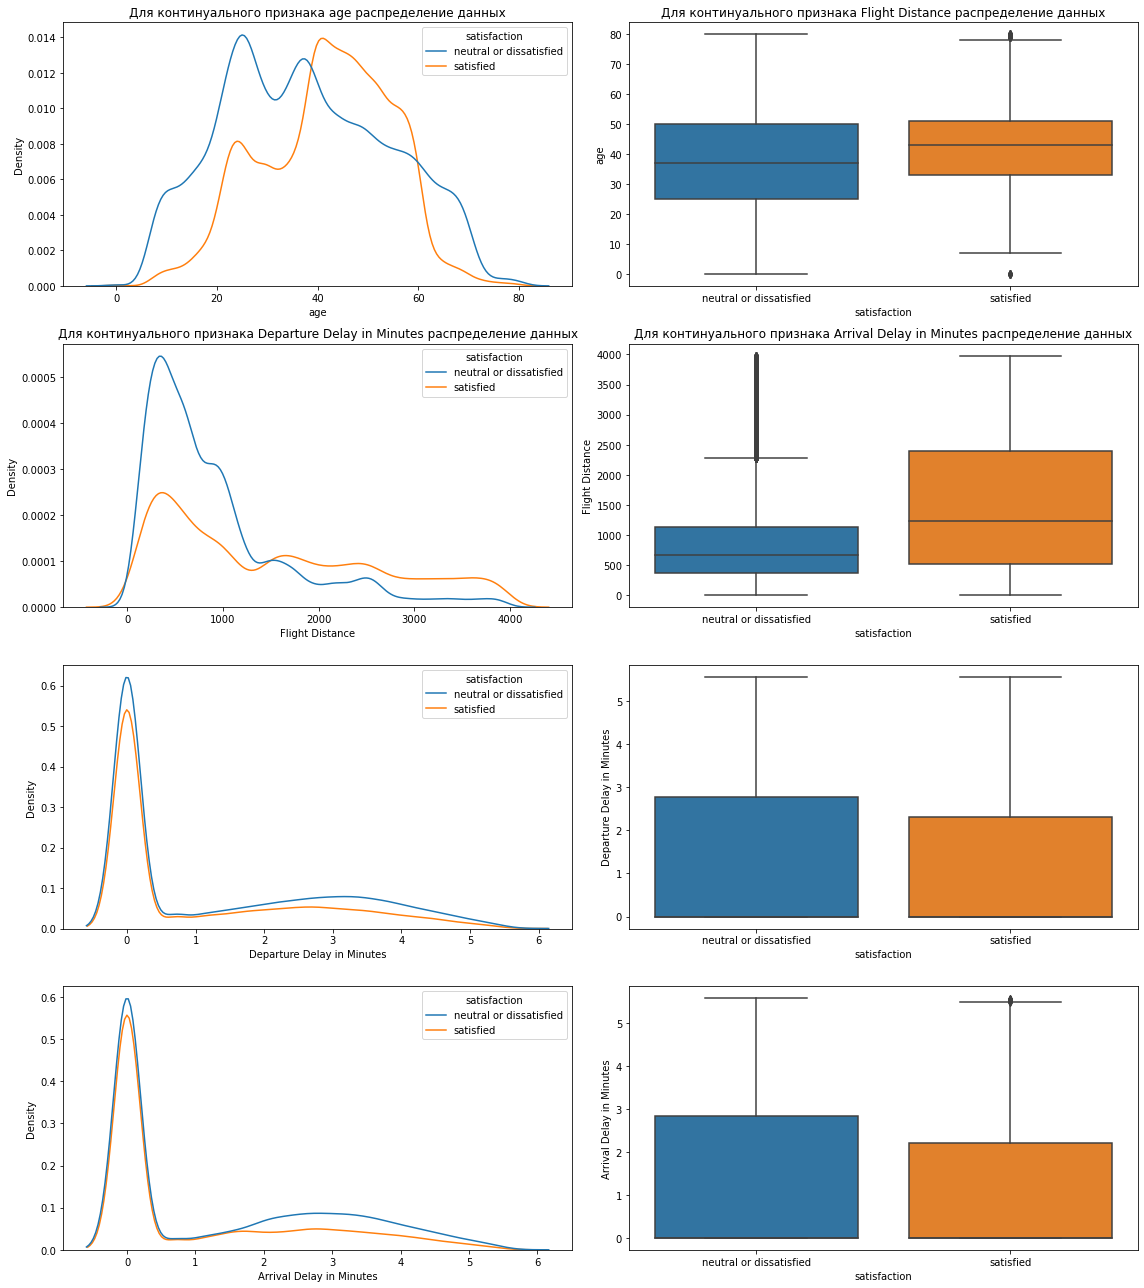

In [127]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [18]:
y_train = y_train.apply(lambda x: 1 if x == 'satisfied' else 0)
y_val = y_val.apply(lambda x: 1 if x == 'satisfied' else 0)

In [19]:
y_train.head()

id
32806    0
66453    0
90663    1
68907    1
55080    0
Name: satisfaction, dtype: int64

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

In [20]:
df_cd = pd.merge(X_train, y_train, how='inner', on = 'id')

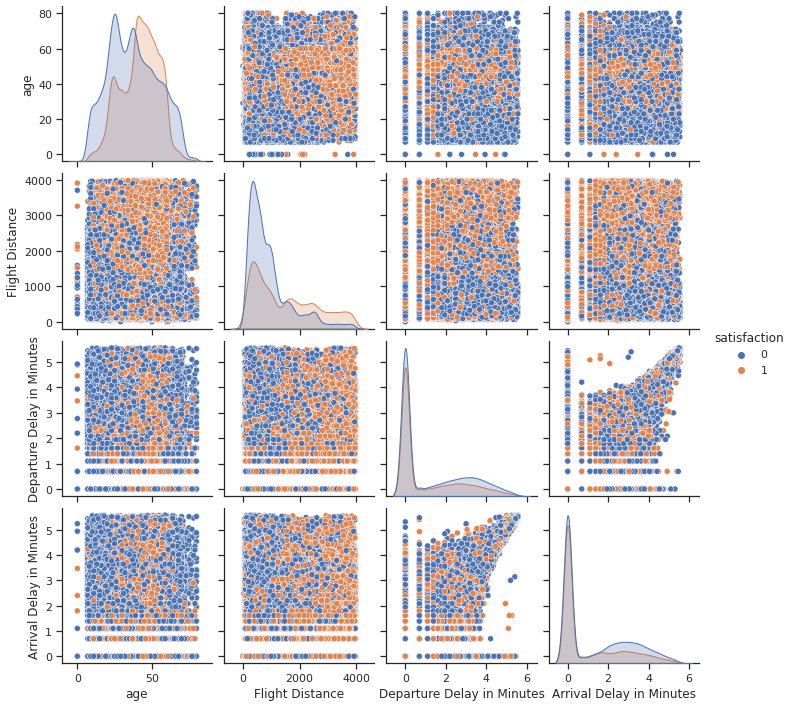

In [ ]:
pplot = sns.pairplot(df_cd, hue='satisfaction', vars=continuous_cols);

<font color='#9933CC'>Отобразите тепловую карту корреляций признаков и таргета</font>

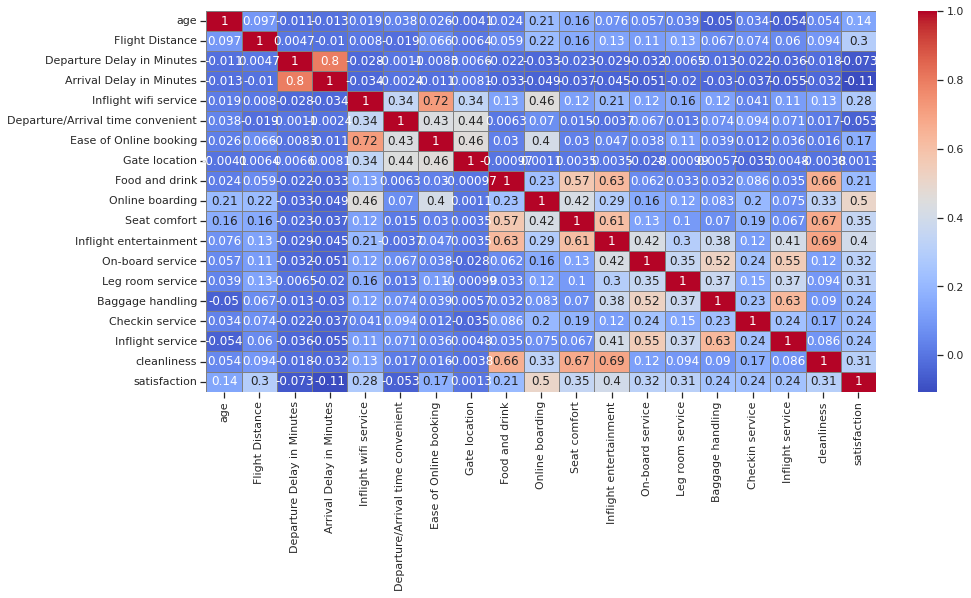

In [46]:
plt.figure(figsize = (15,7))
sns.heatmap(df_cd.corr(), annot = True, cmap= 'coolwarm', linewidths=1, linecolor='grey');

Видим, что с целевой переменной ни у одного признака нет выраженной корреляции. Самая большая у 'Online boarding'. Дальше проверим, информативен ли этот признак для предсказания удовлетворенности

<img src='https://mobimg.b-cdn.net/v3/fetch/fe/fe22186dba2df35f07573604aa8a0e63.jpeg?w=1470&r=0.5625' height=500px>

# Decision Tree (1.75 балла)

(0.25 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [21]:
one_hot = pd.get_dummies(X_train[categorical_cols])
X_train = X_train.drop(categorical_cols, axis=1)
X_train = X_train.join(one_hot)
one_hot = pd.get_dummies(X_val[categorical_cols])
X_val = X_val.drop(categorical_cols, axis=1)
X_val = X_val.join(one_hot)

<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для теста

In [20]:
from sklearn.model_selection import cross_val_score
# https://www.datacamp.com/tutorial/decision-tree-classification-python

dtreecl = DecisionTreeClassifier(random_state=123)
dtreecl.fit(X_train, y_train)
y_val_pred = dtreecl.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
#cross_val_score(clf, X_train, y_train, cv=10)

Accuracy: 0.9313273873697279


## Деревья решений. Теоретическая вставка

(0.25 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [19]:
# change *params into what needs to be there by task condition
# http://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/
error_dt, bias_dt, var_dt = bias_variance_decomp(dtreecl, X_train.values, y_train.values, X_val.values, y_val.values, 
                                                 loss='0-1_loss',
                                                 random_seed=123)
error_dt, bias_dt, var_dt
# (0.060881557990250496, 0.04088035136830928, 0.04455644577440997)

(0.0737706230193734, 0.04149106471952694, 0.05798114933516286)

## Возвращение к задаче

(0.25 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

In [52]:
# Extract the feature importances into a dataframe
feature_results_dt = pd.DataFrame({'feature': list(X_train.columns), 
                                'importance': dtreecl.feature_importances_})

# Show the top 10 most important
#feature_results_dt = feature_results_dt.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results_dt.head(10)

feature  importance
0                                age    0.022678
1                    Flight Distance    0.024256
2         Departure Delay in Minutes    0.006582
3           Arrival Delay in Minutes    0.009491
4              Inflight wifi service    0.181801
5  Departure/Arrival time convenient    0.006438
6             Ease of Online booking    0.003837
7                      Gate location    0.018937
8                     Food and drink    0.004634
9                    Online boarding    0.361093

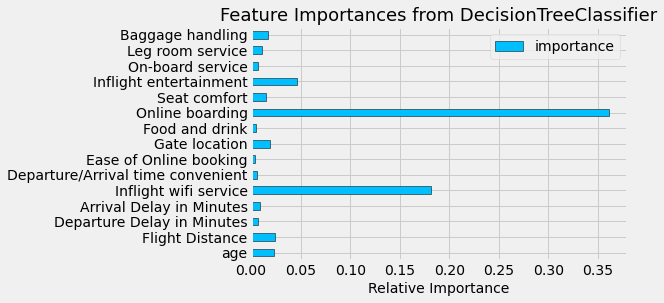

In [53]:
#from matplotlib import style


plt.style.use('fivethirtyeight');
# Plot the 15 most important features in a horizontal bar chart
feature_results_dt.loc[:14, :].plot(x = 'feature', y = 'importance', 
                                 color='deepskyblue',
                                 edgecolor = 'k',
                                 kind='barh');
plt.xlabel('Relative Importance', size = 14); plt.ylabel('');
plt.title('Feature Importances from DecisionTreeClassifier', size = 18);

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

In [ ]:
🐛 Наиболее информативными признаками согласно графику являются признаки: 
    Online boarding (~0.36)
    Inflight wifi service (~0.18)
    Type of Travel_Personal Travel (~0.14)
остальные < 0.05

<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [67]:
help(tree.tree_)

Help on Tree object:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leave

In [23]:
print('depth of the tree',dtreecl.tree_.max_depth)
print('number of leaves', dtreecl.tree_.n_leaves)

depth of the tree 37
number of leaves 2827


<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [24]:
X_train_red = X_train.filter(items=['Online boarding', 'Inflight wifi service'])
X_val_red = X_val.filter(items=['Online boarding', 'Inflight wifi service'])

Accuracy: 0.82


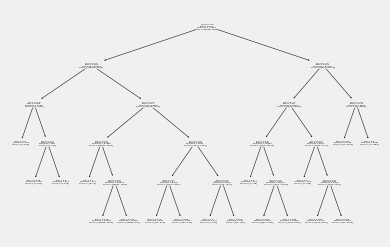

In [25]:
model = DecisionTreeClassifier(max_depth=5, random_state=123)
model.fit(X_train_red, y_train)

print(f"Accuracy: {accuracy_score(y_val, model.predict(X_val_red)):.2f}")
plot_tree(model);

In [ ]:
🐳 accuracy_score упал с 0.93 до 0.82. Причиной является то, что 'Feature Importances' показывает не полную картину важности 
признаков.

(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

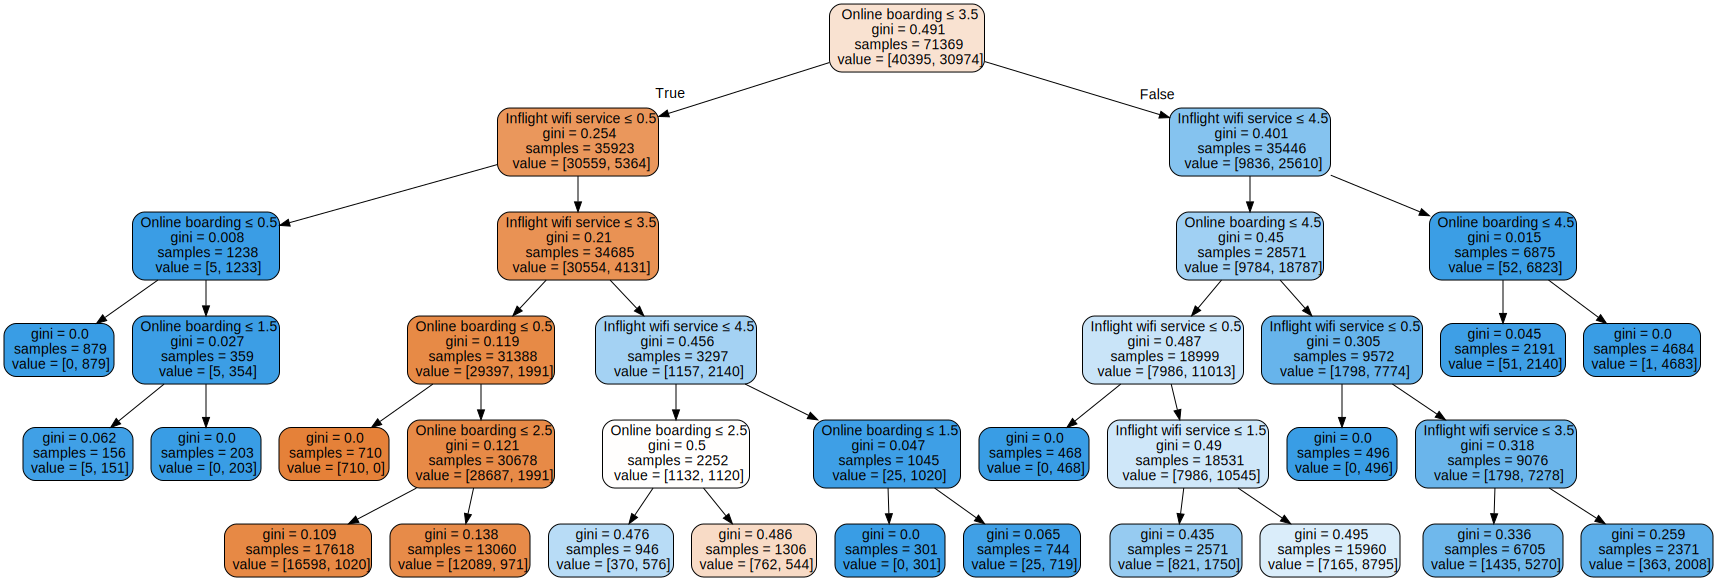

In [26]:
# https://stackoverflow.com/questions/42621190/display-this-decision-tree-with-graphviz
from sklearn import tree
import graphviz


dot_data = tree.export_graphviz(model, 
                                feature_names=['Online boarding', 'Inflight wifi service'],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                out_file=None,
                               )
graph = graphviz.Source(dot_data)
graph

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договореённости) признаков</font>

In [27]:
X_train_red = X_train.filter(items=['Flight Distance', 'age'])
X_val_red = X_val.filter(items=['Flight Distance', 'age'])
model = DecisionTreeClassifier(max_depth=5, random_state=123)
model.fit(X_train_red, y_train)

print(f"Accuracy: {accuracy_score(y_val, model.predict(X_val_red)):.2f}")

Accuracy: 0.68


(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

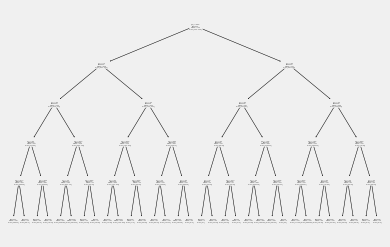

In [28]:
plot_tree(model);

In [ ]:
🐠 не очень хорошо, логически в реальности сложно представить, что все предикаты могут быть подобраны таким образом, и по скору видно, что для значения 0.82 
дерево было несимметричным, а здесь оно симметрично.

(0.25 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


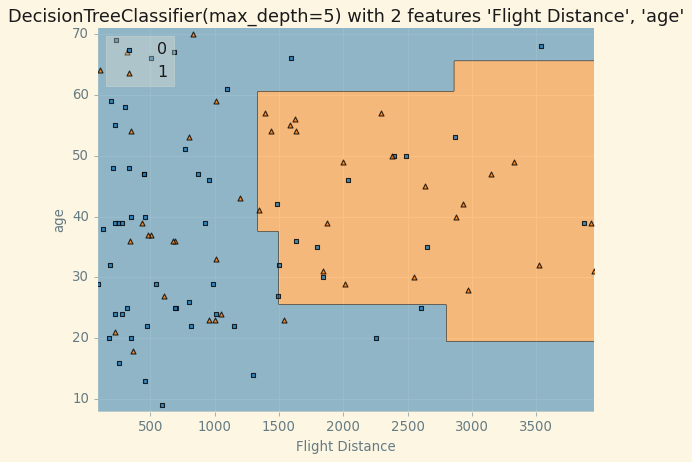

In [88]:
# Plotting decision regions
plt.style.use('Solarize_Light2');
plot_decision_regions(X_val_red[:100].values, y_val[:100].values, clf=model, legend=2)

# Adding axes annotations
plt.xlabel('Flight Distance')
plt.ylabel('age')
plt.title("DecisionTreeClassifier(max_depth=5) with 2 features 'Flight Distance', 'age'")
plt.show()

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


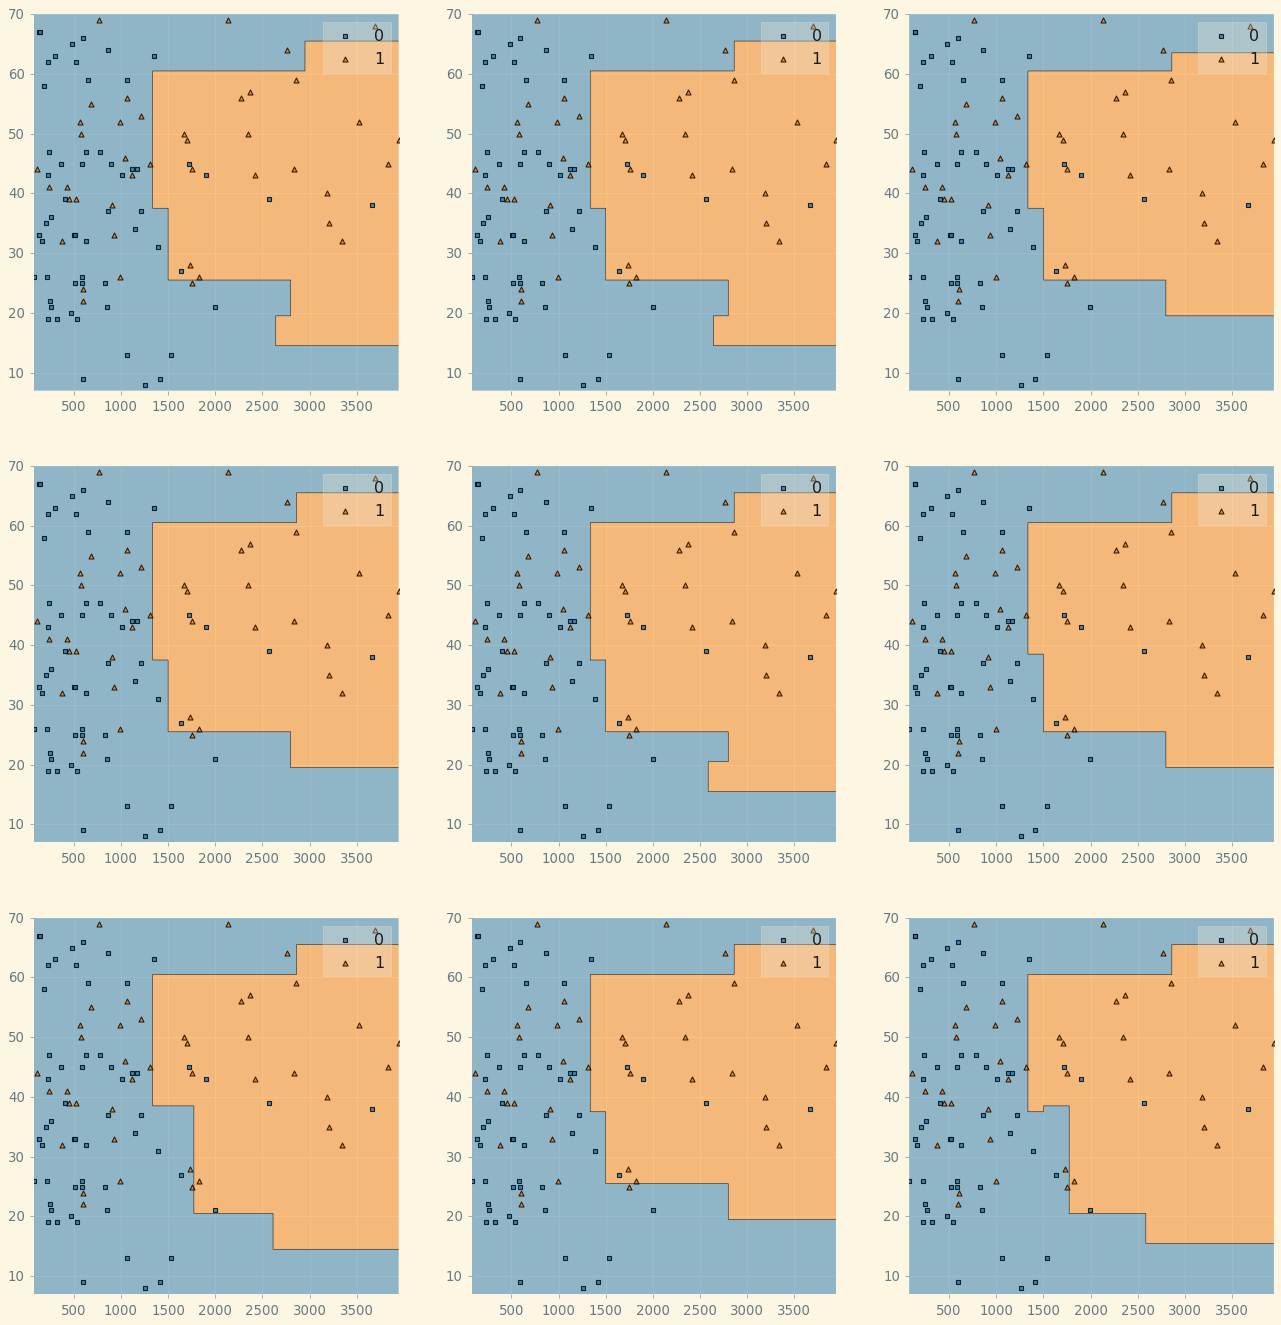

In [89]:
# change X_train_example to your equivalent

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_red.index, size=X_train_red.shape[0] - 1000, replace=False)

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_red.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_red.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [90]:
# change X_train_enc into your ohe-encoded train set

#%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train, y_train)
    y_predicted_train = DT.predict(X_train)
    y_predicted_val = DT.predict(X_val)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

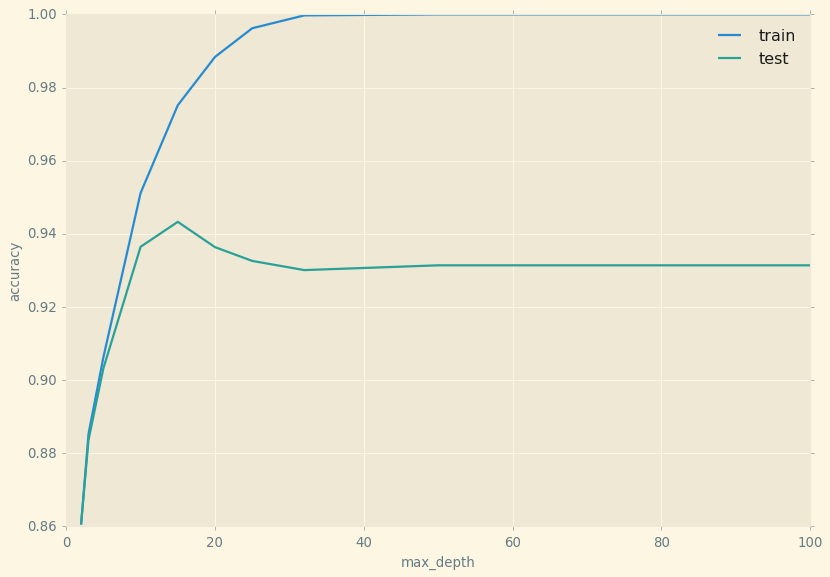

In [91]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.25 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font>. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [128]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
tree_params = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5)
clf.fit(X_train, y_train)


sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_criterion',
 'param_max_depth',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [175]:
print('best_params:', clf.best_params_)
print('best_score:', clf.best_score_)

best_params: {'criterion': 'gini', 'max_depth': 15}
best_score: 0.9500763563836913


In [137]:
clf

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]})

<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [172]:
best_model = DecisionTreeClassifier(max_depth=15, random_state=123)
best_model.fit(X_train, y_train)
pickle.dump(best_model, open('DT.pkl', 'wb'))

In [26]:
with open('DT.pkl', 'rb') as f:
    pickled_model = pickle.load(f)
result = pickled_model.score(X_val, y_val)
print(result)

0.9438727171746872


# Random Forest (2 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [27]:
rand_forest = RandomForestClassifier(random_state=123)
rand_forest.fit(X_train, y_train)

y_predicted_val = rand_forest.predict(X_val)
print('accuracy score:', accuracy_score(y_val, y_predicted_val))

accuracy score: 0.9608938547486033


(0.25 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

Text(0.5, 1.0, 'Calibration plots (Naive Bayes)')

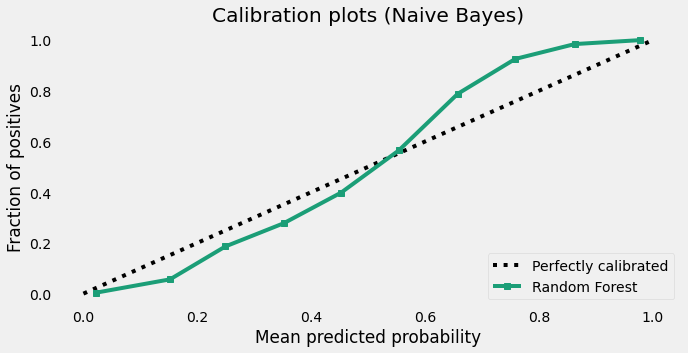

In [25]:
from matplotlib.gridspec import GridSpec


clf_list = [
    (rand_forest, "Random Forest")
]
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_val,
        y_val,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

In [ ]:
# your answer below
# feel free to change this cell into markdown



<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

In [28]:
lr = LogisticRegression(random_state=123, max_iter=1000)
lr.fit(X_train, y_train)

y_predicted_val = lr.predict(X_val)
print('accuracy score:', accuracy_score(y_val, y_predicted_val))

accuracy score: 0.8135842399294325


Text(0.5, 1.0, 'Calibration plots (Naive Bayes)')

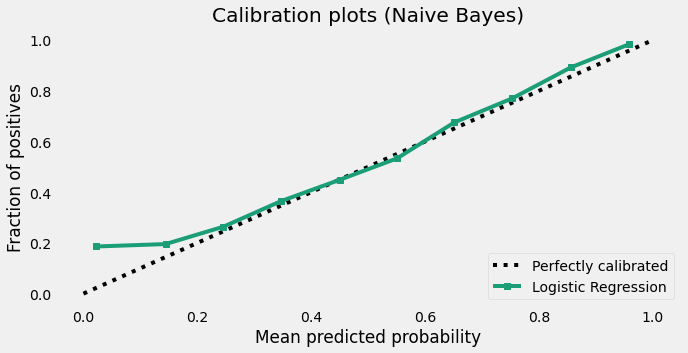

In [27]:
clf_list = [
    (lr, "Logistic Regression")
]
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_val,
        y_val,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

(0.25 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

In [29]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay


rf_isotonic = CalibratedClassifierCV(rand_forest, cv=3, method="isotonic", n_jobs=-1)
rf_sigmoid = CalibratedClassifierCV(rand_forest, cv=3, method="sigmoid", n_jobs=-1)

clf_list = [
    (rf_isotonic, "Random Forest + Isotonic"),
    (rf_sigmoid, "Random Forest + Sigmoid"),
]

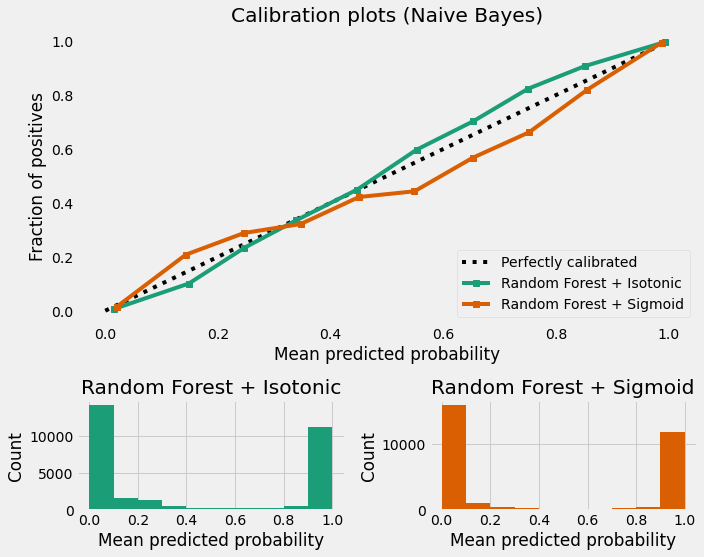

In [39]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_val,
        y_val,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [ ]:
🦒 По графикам видно, что кривая калибровочная для метода 'Random Forest + Isotonic' лежит ближе к идеальной кривой.

<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

In [ ]:
# https://webiomed.ru/blog/kalibrovka-modelei-zachem-i-kak/
# https://alexanderdyakonov.wordpress.com/2020/03/27/%D0%BF%D1%80%D0%BE%D0%B1%D0%BB%D0%B5%D0%BC%D0%B0-%D0%BA%D0%B0%D0%BB%D0%B8%D0%B1%D1%80%D0%BE%D0%B2%D0%BA%D0%B8-%D1%83%D0%B2%D0%B5%D1%80%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8/


(0.25 балла) <font color='#9933CC'>Посчитайте разброс и смещение полученной композиции.</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [41]:
error_rf_isotonic, bias_rf_isotonic, var_rf_isotonic = bias_variance_decomp(rf_isotonic, X_train.values, y_train.values, X_val.values, y_val.values, 
                                                 loss='0-1_loss',
                                                 random_seed=123)
error_rf_isotonic, bias_rf_isotonic, var_rf_isotonic

(0.04096964944950831, 0.03998823875330785, 0.007987846711751446)

<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [66]:
error_lr, bias_lr, var_lr = bias_variance_decomp(lr, X_train.values, y_train.values, X_val.values, y_val.values, 
                                                 loss='0-1_loss',
                                                 random_seed=123)
error_lr, bias_lr, var_lr

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

(0.18492779901336207, 0.18504361462315005, 0.0059098631121565545)

(0.25 балла) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [40]:
# https://www.kaggle.com/code/funxexcel/p3-random-forest-tuning-randomizedsearchcv/notebook
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from scipy.stats import uniform


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
#[10, 17, 25, 33, 41, 48, 56, 64, 72, 80]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#uniform(loc=10, scale=80)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
clf = RandomizedSearchCV(rand_forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
search = clf.fit(X_train, y_train)
search.best_params_

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=644; total time=  37.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=644; total time=  37.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=644; total time=  38.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  12.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  11.3s
[C

{'n_estimators': 733,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

In [107]:
# https://www.kaggle.com/code/funxexcel/p3-random-forest-tuning-randomizedsearchcv/notebook
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from scipy.stats import uniform


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
#[10, 17, 25, 33, 41, 48, 56, 64, 72, 80]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = uniform(loc=10, scale=110)
#[int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
clf = RandomizedSearchCV(rand_forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
search = clf.fit(X_train, y_train)
search.best_params_

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6bbeca81c0>, 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=97.61972855462561, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=555; total time=  20.9s
[CV] END bootstrap=True, max_depth=97.61972855462561, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=555; total time=  20.4s
[CV] END bootstrap=True, max_depth=97.61972855462561, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=555; total time=  20.2s
[CV] END bootstrap=True, max_depth=59.041602813895025, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=822; total time=  30.1s
[CV] END bootstrap=True, max_depth=59.041602813895

KeyboardInterrupt: 

## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [67]:
# change X_train_enc into you equivalent

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


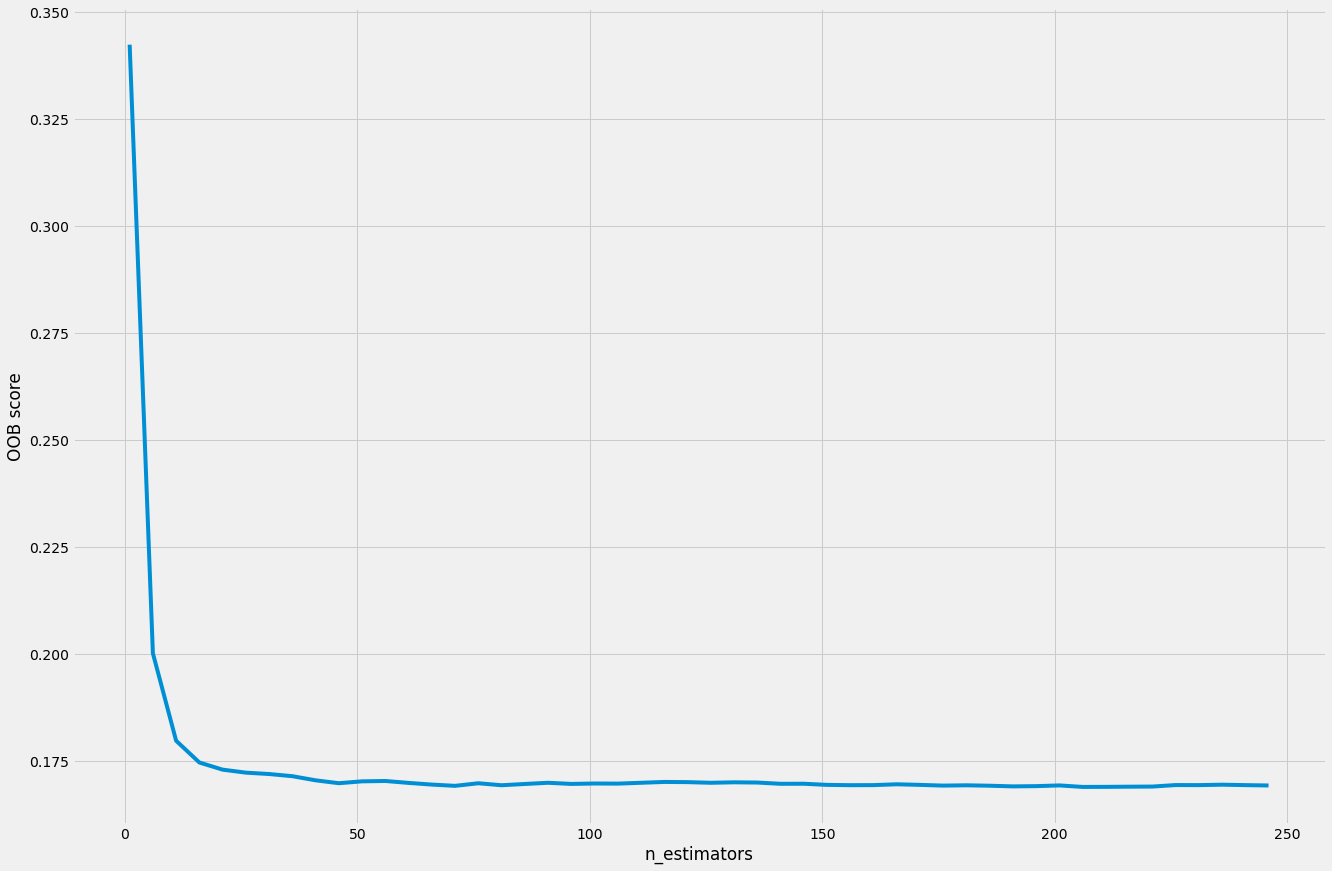

In [68]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

In [178]:
# Extract the feature importances into a dataframe
rf_best =  RandomForestClassifier(n_estimators= 733, 
                                  min_samples_split = 5,
                                  min_samples_leaf = 1,
                                  max_features = 'auto',
                                  max_depth = 90,
                                  bootstrap = False, 
                                  random_state=123)
rf_best.fit(X_train, y_train);
feature_results_rf_best = pd.DataFrame({'feature': list(X_train.columns), 
                                'importance': rf_best.feature_importances_})

# Show the top 10 most important
# feature_results_rf_best = feature_results_rf_best.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results_rf_best.head(10)

feature  importance
0                                age    0.024574
1                    Flight Distance    0.024142
2         Departure Delay in Minutes    0.008287
3           Arrival Delay in Minutes    0.009844
4              Inflight wifi service    0.144701
5  Departure/Arrival time convenient    0.012486
6             Ease of Online booking    0.036411
7                      Gate location    0.012664
8                     Food and drink    0.008924
9                    Online boarding    0.169176

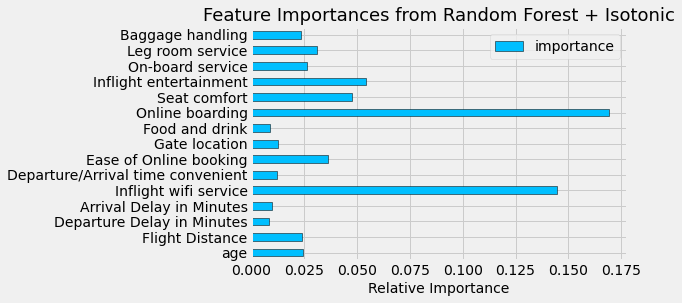

In [54]:
# Plot the 15 most important features in a horizontal bar chart
feature_results_rf_best.loc[:14, :].plot(x = 'feature', y = 'importance', 
                                 color='deepskyblue',
                                 edgecolor = 'k',
                                 kind='barh');
plt.xlabel('Relative Importance', size = 14); plt.ylabel('');
plt.title('Feature Importances from Random Forest + Isotonic', size = 18);

In [40]:
y_predicted = rf_best.predict(X_val)
print('accuracy score:', accuracy_score(y_val, y_predicted))

accuracy score: 0.9617759482505146


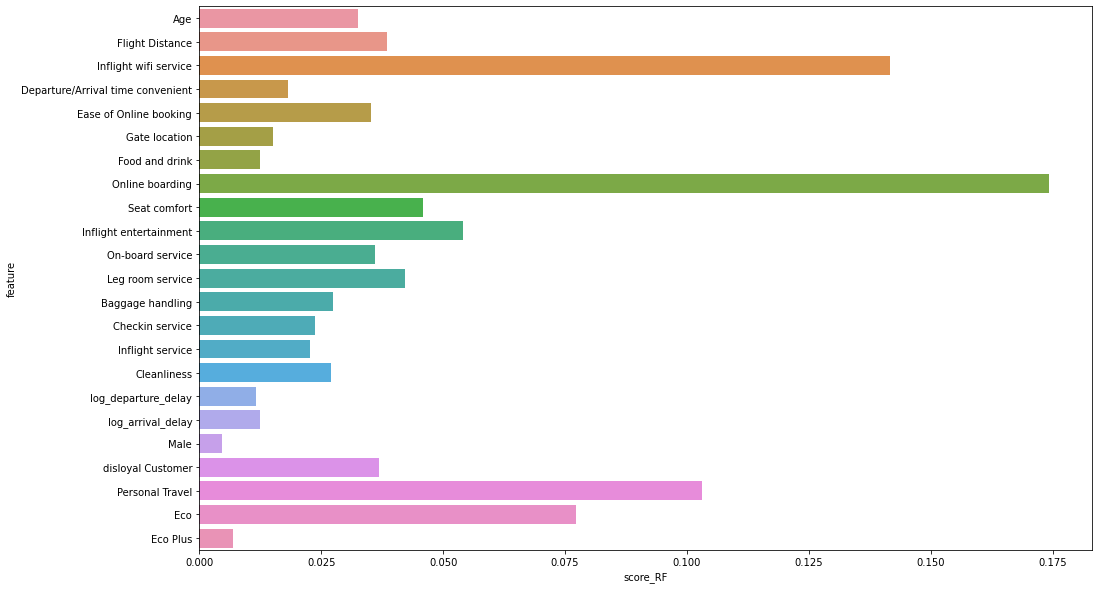

In [ ]:
# (•_•)

(0.25 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

In [99]:
feature_results_rf_best['model'] = 'rf_best'
feature_results_dt['model'] = 'dt'
feature_results_dt_rf = pd.concat([feature_results_rf_best, feature_results_dt]).reset_index()
feature_results_dt_rf.sample(5)

index                         feature  importance    model
31      4           Inflight wifi service    0.181801       dt
3       3        Arrival Delay in Minutes    0.009844  rf_best
35      8                  Food and drink    0.004634       dt
23     23  Type of Travel_Personal Travel    0.056498  rf_best
26     26                  class_Eco Plus    0.002202  rf_best

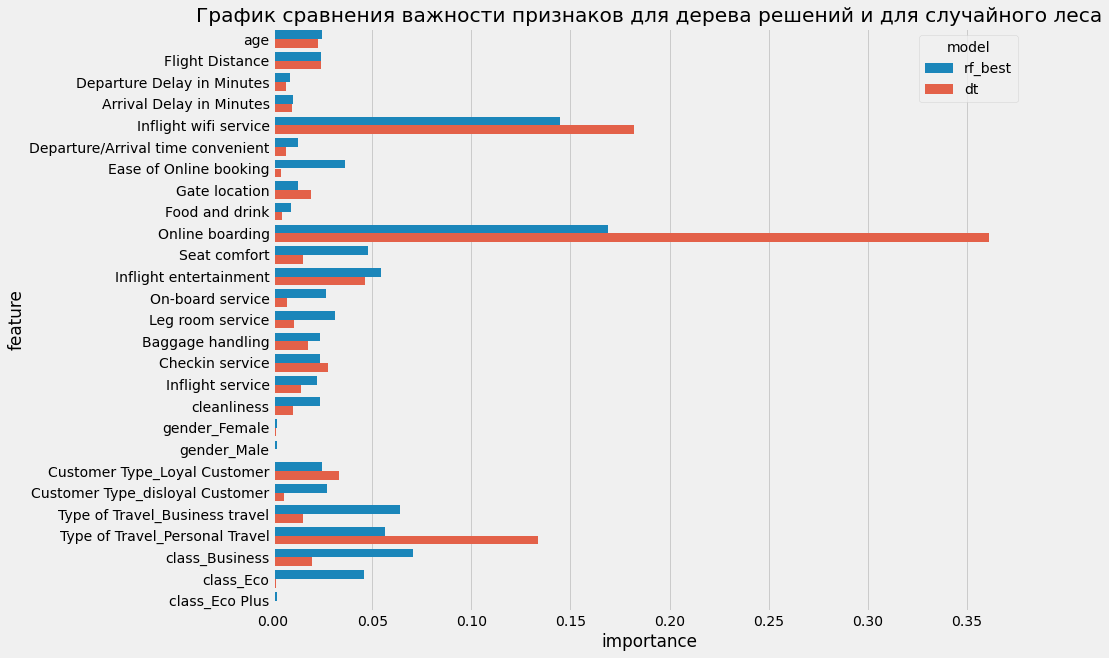

In [104]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(data = feature_results_dt_rf, 
            y = 'feature', 
            x = 'importance', 
            hue = 'model', 
            ax = ax).set_title('График сравнения важности признаков для дерева решений и для случайного леса');

(0.25 балла) <font color='#9933CC'>Оцените Permutation Importance вашео случайного леса</font>. Загляните в [документацию библиотеки eli5](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance)

In [106]:
from eli5.sklearn import PermutationImportance


perm = PermutationImportance(rf_best, scoring="balanced_accuracy")
perm.fit(X_val, y_val)
eli5.show_weights(perm, feature_names=X_val.columns.tolist())

<font color='#FF6600'>Изучите документацию библиотеки eli5. Перечислите полезные инструменты из неё, которые вам хотелось бы попробовать: </font>

🐦 источник https://stats.stackexchange.com/questions/555949/how-to-interpret-the-feature-importances-for-eli5-show-weights-for-regressio
Согласно ссылке выше и документации метод 'show_weights' неполно описывает важность признаков. После обучения *perm.fit(X_val, y_val)* объект *perm* содержит аттрибуты https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#module-eli5.sklearn.permutation_importance, которые содержат важную информацию о влиянии признаков на результат предсказания.
Можно использовать методы *perm.feature_importances_* и *perm.results_*.

(0.25 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [148]:
# Extract the names of the most important features
feature_results_rf_best_sorted = feature_results_rf_best.sort_values(by='importance', ascending=False)
most_important_features = feature_results_rf_best_sorted['feature'][:10]

# Find the index that corresponds to each feature name
#indices = [list(X_train.columns).index(x) for x in most_important_features]
# Keep only the most important features
X_train_reduced = X_train[most_important_features.values.tolist()]
X_val_reduced = X_val[most_important_features.values.tolist()]

print('Most important training features shape: ', X_train_reduced.shape)
print('Most important testing  features shape: ', X_val_reduced.shape)

Most important training features shape:  (71369, 10)
Most important testing  features shape:  (30609, 10)


Online boarding  Inflight wifi service  class_Business  \
id                                                              
32806              3.0                    2.0               1   
66453              2.0                    2.0               0   
90663              4.0                    2.0               1   
68907              4.0                    4.0               0   
55080              3.0                    3.0               0   
...                ...                    ...             ...   
7935               5.0                    3.0               1   
68680              3.0                    4.0               0   
96209              3.0                    3.0               1   
1082               3.0                    3.0               0   
19805              2.0                    3.0               1   

       Type of Travel_Business travel  Type of Travel_Personal Travel  \
id                                                                      
32806                               1                               0   
66453                               0                               1   
90663                               1                               0   
68907                               0                               1   
55080                               1                               0   
...                               ...                             ...   
7935                                0                               1   
68680                               1                               0   
96209                               1                               0   
1082                                0                               1   
19805                               1                               0   

       Inflight entertainment  Seat comfort  class_Eco  \
id                                                       
32806                     3.0           3.0          0   
66453                     5.0           5.0          1   
90663                     4.0           5.0          0   
68907                     2.0           2.0          1   
55080                     3.0           3.0          1   
...                       ...           ...        ...   
7935                      3.0           4.0          0   
68680                     4.0           1.0          1   
96209                     3.0           3.0          0   
1082                      4.0           4.0          1   
19805                     4.0           1.0          0   

       Ease of Online booking  Leg room service  
id                                               
32806                     4.0               3.0  
66453                     2.0               2.0  
90663                     2.0               4.0  
68907                     4.0               3.0  
55080                     2.0               3.0  
...                       ...               ...  
7935                      3.0               3.0  
68680                     5.0               4.0  
96209                     5.0               2.0  
1082                      3.0               2.0  
19805                     3.0               4.0  

[71369 rows x 10 columns]

In [153]:
import shap
shap.initjs()
rf_best_reduced = RandomForestClassifier(n_estimators= 733, 
                                  min_samples_split = 5,
                                  min_samples_leaf = 1,
                                  max_features = 'auto',
                                  max_depth = 90,
                                  bootstrap = False, 
                                  random_state=123)
rf_best_reduced.fit(X_train_reduced.values, y_train.values)
gb_explainer = shap.KernelExplainer(rf_best_reduced.predict, X_val_reduced[1000:1100])
gb_shap_values = gb_explainer.shap_values(X_val_reduced[1000:1100])

  0%|          | 0/100 [00:00<?, ?it/s]

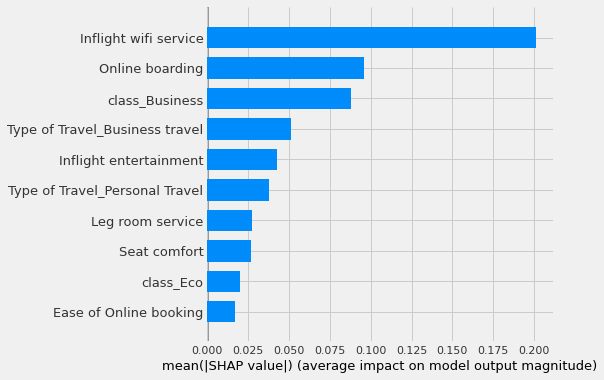

In [162]:
shap.summary_plot(gb_shap_values, X_val_reduced[1000:1100], plot_type="bar", feature_names = list(most_important_features))

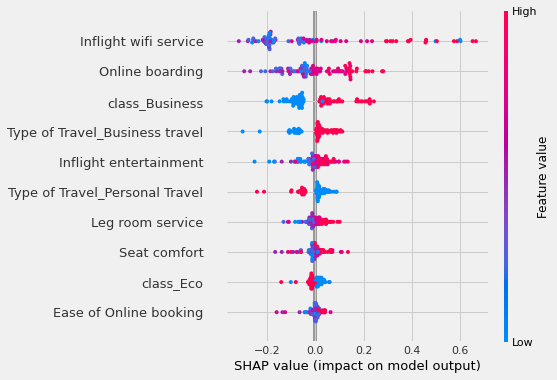

In [165]:
shap.summary_plot(gb_shap_values, X_val_reduced[1000:1100], feature_names = list(most_important_features))

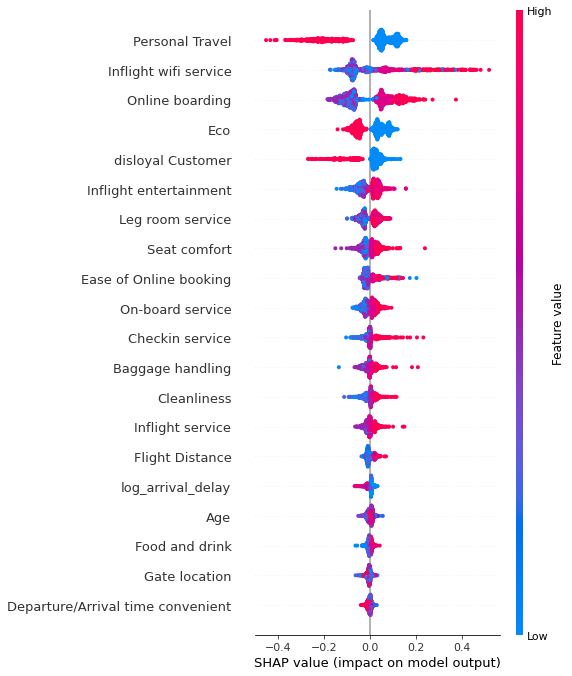

CPU times: user 5min 45s, sys: 2.77 s, total: 5min 47s
Wall time: 5min 45s


In [ ]:
# (•_•)


<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below


<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

In [ ]:
# feel free to change this cell into markdown



(0.25 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [167]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_train_reduced.values, 
                                                   mode = 'regression',
                                                   training_labels = y_train.values,
                                                   feature_names = list(most_important_features))

Prediction: 0.0000
Actual Value: 1.0000


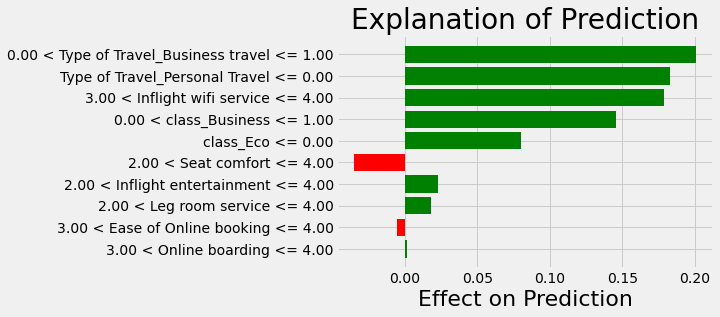

In [172]:
y_pred_reduced = rf_best_reduced.predict(X_val_reduced.values)
# Find the residuals
residuals = abs(y_pred_reduced - y_val)
# Exact the worst and best prediction
wrong = X_val_reduced.values[np.argmax(residuals), :]
right = X_val_reduced.values[np.argmin(residuals), :]
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % rf_best_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_val.values[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = rf_best_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [173]:
wrong_exp.show_in_notebook(show_predicted_value=False)

Prediction: 1.0000
Actual Value: 1.0000


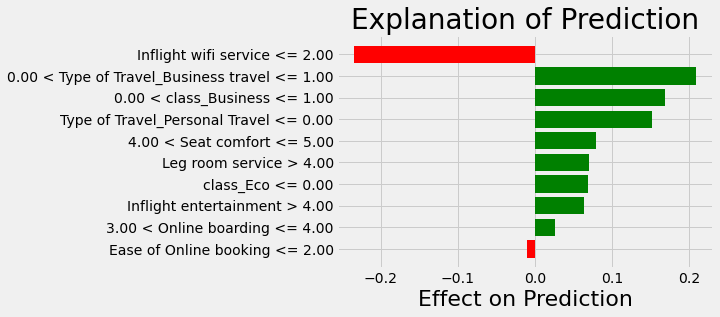

In [174]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % rf_best_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_val.values[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, rf_best_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [175]:
right_exp.show_in_notebook(show_predicted_value=False)

<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below


<font color='#9933CC'>Случайное дерево, дающее лучший скор, сохраните в pickle</font>

In [179]:
pickle.dump(rf_best, open('RF.pkl', 'wb'))

In [180]:
with open('RF.pkl', 'rb') as f:
    pickled_model = pickle.load(f)
result = pickled_model.score(X_val, y_val)
print(result)

0.9617759482505146


# Бустинги (1 балл)

## CatBoost (0.25 балла)

(0.25 балла) <font color='#9933CC'>Обучите pipeline из стандартизации континуальных (как договаривались) признаков и `CatBoostClassifier` с параметрами по умолчанию</font>. `StandardScaler` из sklearn не подойдет. Напишите свой собственный, который не будет изменять остальные фичи.

In [52]:
from sklearn.base import TransformerMixin


class MyStandardScaler(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''

    def __init__(self, cols):
        self.cols = cols
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        num_cols = X.copy()[self.cols]
        self.scaler.fit(num_cols)
        return self

    def transform(self, X):
        X_res = X.copy()
        num_cols_tr = self.scaler.transform(X_res[self.cols])
        for i, col in enumerate(self.cols):
            X_res[col] = num_cols_tr[:,i]
        return X_res


In [68]:
pipelineCatBoost = Pipeline([
    ('scaler_', MyStandardScaler(continuous_cols)),
    ('model_', CatBoostClassifier())
    ])
pipelineCatBoost.fit(X_train, y_train)

#print(p1)

y_pred = pipelineCatBoost.predict(X_val)

print(accuracy_score(y_val, y_pred))

Learning rate set to 0.063736
0:	learn: 0.6071630	total: 9.8ms	remaining: 9.79s
1:	learn: 0.5365831	total: 20.2ms	remaining: 10.1s
2:	learn: 0.4577484	total: 29.9ms	remaining: 9.95s
3:	learn: 0.4202316	total: 40ms	remaining: 9.97s
4:	learn: 0.3740639	total: 50.9ms	remaining: 10.1s
5:	learn: 0.3426831	total: 60.7ms	remaining: 10.1s
6:	learn: 0.3231596	total: 70.3ms	remaining: 9.97s
7:	learn: 0.3014202	total: 92.8ms	remaining: 11.5s
8:	learn: 0.2824396	total: 110ms	remaining: 12.1s
9:	learn: 0.2689921	total: 124ms	remaining: 12.3s
10:	learn: 0.2556366	total: 134ms	remaining: 12.1s
11:	learn: 0.2398357	total: 155ms	remaining: 12.7s
12:	learn: 0.2283496	total: 175ms	remaining: 13.3s
13:	learn: 0.2193736	total: 190ms	remaining: 13.4s
14:	learn: 0.2126987	total: 202ms	remaining: 13.2s
15:	learn: 0.2046591	total: 212ms	remaining: 13s
16:	learn: 0.1972884	total: 222ms	remaining: 12.8s
17:	learn: 0.1919064	total: 233ms	remaining: 12.7s
18:	learn: 0.1874468	total: 253ms	remaining: 13.1s
19:	lear

<font color='#9933CC'>Сохраните себе `feature_importances_` катбуста</font>. Дальше они вам пригодятся

In [69]:
feature_results_CatBoost = pd.DataFrame({'feature': list(X_train.columns), 
                                'importance': pipelineCatBoost[1].feature_importances_})

feature_results_CatBoost.head(10)

feature  importance
0                                age    3.431875
1                    Flight Distance    2.091333
2         Departure Delay in Minutes    0.443489
3           Arrival Delay in Minutes    0.885813
4              Inflight wifi service   26.692114
5  Departure/Arrival time convenient    1.690776
6             Ease of Online booking    1.468974
7                      Gate location    3.864413
8                     Food and drink    0.342623
9                    Online boarding    6.995519

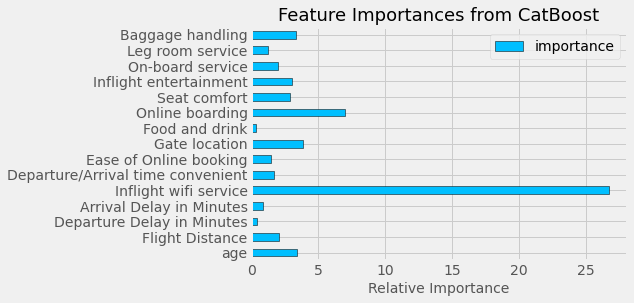

In [70]:
# Plot the 15 most important features in a horizontal bar chart
plt.style.use('fivethirtyeight');
feature_results_CatBoost.loc[:14, :].plot(x = 'feature', y = 'importance', 
                                 color='deepskyblue',
                                 edgecolor = 'k',
                                 kind='barh');
plt.xlabel('Relative Importance', size = 14); plt.ylabel('');
plt.title('Feature Importances from CatBoost', size = 18);

## XGBoost + optuna (0.5 балла)

<font color='#9933CC'>Обучите `XGBClassifier` с параметрами по умолчанию</font>

In [71]:
pipelineXGBoost = Pipeline([
    ('scaler_', MyStandardScaler(continuous_cols)),
    ('model_', XGBClassifier())
    ])
pipelineXGBoost.fit(X_train, y_train)

y_pred = pipelineXGBoost.predict(X_val)

print(accuracy_score(y_val, y_pred))

0.9605998235812996


(0.5 балла) <font color='#9933CC'>Оптуной подберите лучшие гиперпараметры для XGBoost</font>

Полезные ссылки: [тык1](https://optuna.readthedocs.io/en/stable/), [тык2](https://habr.com/ru/post/704432/)

In [82]:
# (•_•)
def objective(trial):
    
    # Invoke suggest methods of a Trial object to generate hyperparameters.
    regressor_name = trial.suggest_categorical('classifier', ['xgboost'])
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
    regressor_obj = XGBClassifier()

    regressor_obj.fit(X_train, y_train)
    y_pred = regressor_obj.predict(X_val)

    error = accuracy_score(y_val, y_pred)

    return error  # An objective value linked with the Trial object.


In [83]:
%%time
study = optuna.create_study(study_name="xgboost", direction='maximize')
study.optimize(objective, n_trials=10, )

[I 2023-02-12 02:19:42,028] A new study created in memory with name: xgboost
[I 2023-02-12 02:19:44,560] Trial 0 finished with value: 0.9605998235812996 and parameters: {'classifier': 'xgboost', 'rf_max_depth': 18}. Best is trial 0 with value: 0.9605998235812996.
[I 2023-02-12 02:19:47,024] Trial 1 finished with value: 0.9605998235812996 and parameters: {'classifier': 'xgboost', 'rf_max_depth': 18}. Best is trial 0 with value: 0.9605998235812996.
[I 2023-02-12 02:19:49,488] Trial 2 finished with value: 0.9605998235812996 and parameters: {'classifier': 'xgboost', 'rf_max_depth': 26}. Best is trial 0 with value: 0.9605998235812996.
[I 2023-02-12 02:19:52,023] Trial 3 finished with value: 0.9605998235812996 and parameters: {'classifier': 'xgboost', 'rf_max_depth': 3}. Best is trial 0 with value: 0.9605998235812996.
[I 2023-02-12 02:19:54,494] Trial 4 finished with value: 0.9605998235812996 and parameters: {'classifier': 'xgboost', 'rf_max_depth': 3}. Best is trial 0 with value: 0.96059982

CPU times: user 1min 39s, sys: 198 ms, total: 1min 39s
Wall time: 24.9 s


<font color='#9933CC'>Обучите XGBClassifier c подобранными гиперпараметрами</font>

In [84]:
xgb_best = XGBClassifier(
    **study.best_params,
    random_state=42
)
xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_val)

print(accuracy_score(y_val, y_pred))

[02:21:49] WARNING: ../src/learner.cc:767: 
Parameters: { "classifier", "rf_max_depth" } are not used.

0.9605998235812996


<font color='#9933CC'>Сохраните себе `feature_importances_` xbgoost'а</font>. Дальше они вам пригодятся

In [85]:
feature_results_XGBoost = pd.DataFrame({'feature': list(X_train.columns), 
                                'importance': xgb_best.feature_importances_})

feature_results_XGBoost.head(10)

feature  importance
0                                age    0.005615
1                    Flight Distance    0.003308
2         Departure Delay in Minutes    0.002174
3           Arrival Delay in Minutes    0.005231
4              Inflight wifi service    0.104585
5  Departure/Arrival time convenient    0.005771
6             Ease of Online booking    0.005980
7                      Gate location    0.013162
8                     Food and drink    0.002934
9                    Online boarding    0.413780

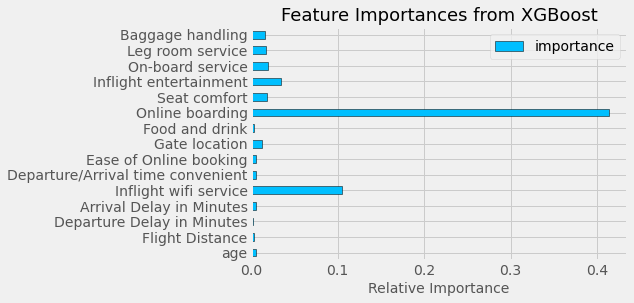

In [86]:
# Plot the 15 most important features in a horizontal bar chart
feature_results_XGBoost.loc[:14, :].plot(x = 'feature', y = 'importance', 
                                 color='deepskyblue',
                                 edgecolor = 'k',
                                 kind='barh');
plt.xlabel('Relative Importance', size = 14); plt.ylabel('');
plt.title('Feature Importances from XGBoost', size = 18);

## LightGBM + Pipeline (0.25 балла)

(0.25 балла) И наконец, <font color='#9933CC'>обучите пайплайн из стандартизации признаков "Age" и "FlightDistance",  нормализации фичей "log_arrival_delay" и "log_departure_delay" и `LGBMClassifier` с параметрами по умолчанию</font>. Вам снова понадобится свой кастомный Scaler, который не будет трогать остальные фичи

In [ ]:
class MyMinMaxScaler(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''

    def __init__(self, cols_to_transform):
        pass

    def fit(self, X, y=None):
        # anything here?
        return self

    def transform(self, X):
        # defenitely here
        pass

In [ ]:
pipe = [
    ('std_scaling', MyStandardScaler(cols_to_transform=['Age', "Flight Distance"])),
    ('min_max', MyMinMaxScaler(cols_to_transform=['log_arrival_delay', "log_departure_delay"])),
    ('lgbm', LGBMClassifier())
]
lgbm_pipeline = Pipeline(pipe)

# your solution goes below


<font color='#9933CC'>Сохраните себе `feature_importances_` lgbm'а</font>. Дальше они вам пригодятся

In [ ]:
# code here


<font color='#9933CC'>Сохраните получившиеся бустинги (лучший xgboost, lgmb и catboost) в pickle</font>

<img src='https://i.imgur.com/qBFSCjZ.jpg' height=500px>

In [ ]:
# your code below



# Стекинг (0.5 балла)

(0.25 балла) <font color='#9933CC'>Воспользуйтесь `StackingClassifier` из skearn для ансаблирования обученных вами к этому шагу моделей</font>

In [ ]:
# code here
%%time


<font color='#9933CC'>Посмотрим, откалиброваны ли полученные после стекинга вероятности</font>

In [ ]:
# -__-

Неожиданно хорошо. Не так ли?

(0.25 балла) <font color='#9933CC'>Постройте ROC- и PR-кривые для полученной композиции. Также выведите другие метрики классификации: F1-score, precision, recall

In [ ]:
# the place for your solution



# Aftermath (1 балл)

В этом домашнем занятии до настоящей ячейки вы обучали модели на всех признаках из обучающей выборки. Давайте под конец попробуем избавиться от признаков, минимально влияющих на результат

Мы довольно часто выводили `feature_importances_` алгоритмов. Пробовали интерпретировать предсказания модели SHAP'ом. Неплохо бы структурировать и валидировать полученные знания.

(0.25 балла) <font color='#9933CC'>Создайте таблицу, в которой для сохраненных вами pickle'ом классификаторов в соответсвующих столбцах будут отранжированные по убыванию `feature_importances_` для этого конкретного классификатора.</font>

По такой таблице должно быть относительно удобно понять, какие признаки (в среднем для разных моделей) важнее остальных для предсказания целевой переменной

In [ ]:
# (•_•)



<font color='#FF6600'>Сделайте выводы: какие 3 признака скорее всего можно удалить?</font>

(0.25 балла) <font color='#9933CC'>Далее для отбора признаков воспользуемся статистическими тестами</font>. Попробуйте отобрать 20 наиболее информативных признака, используя `SelectKBest` из `sklearn.feature_selection`. В качестве статтестов примените (отдельно) `chi2` и `mutual_info_classif`

In [ ]:
# (•_•)



<font color='#FF6600'>Согласуются ли списки признаков-кандитатов на удаление?</font>

In [ ]:
# fell free to change this cell into markdown



(0.25 балла)<font color='#9933CC'>Теперь применим жадные методы отбора признаков</font>. Воспользуйтесь классом `RFECV` для этого. <font color='#FF6600'>Сколько признаков были отобраны как наиболее информативные? Перечислите предложенные к удалению.</font>

In [ ]:
# -____-



(0.25 балла) <font color='#9933CC'>C помощью логистической регрессией с L1-регуляризацией отберите >=5 неифнормативных признака</font>.

In [ ]:
# -____-



<font color='#9933CC'>Удалите 4 признака, которые считаете нужным удалить</font> <font color='#FF6600'>(если хотите больше -- пожалуйста, только обоснуйте целесообразность)</font>. <font color='#9933CC'>Обучите RandomForestClassifier с параметрами по умолчанию на этих признаках</font>. <font color='#FF6600'>Сильно ли уменьшилось качество на валидационной выборке? О чем это говорит?</font>

In [ ]:
# -___-



## Могли попросить, но не попросили (0 баллов, но >0 пользы).

Это домашнее задание уже получилось довольно объемным. Нам хотелось бы добавить ещё несколько (вообще говоря много) заданий -- однако хватит. Ниже некоторые из невошедших заданий

<font color='#29ab87'>На свое усмотрение выберите несколько (>= 3) классификаторов. На кросс-валидации переберите для каждого из них несколько (>=4) значений одного гиперпараметра. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра. На этом же графике изобразите доверительный интервал `[mean - std; mean + std]`</font>

<font color='#29ab87'>Для любой из модификаций бустинга (выберите себе по душе) постройте график ошибки композиции в зависимости от числа деревьев. Подберите гиперпараметр `n_estimators` по этому графику и обоснуйте свой выбор. Какую форму имеет получившаяся у вас ошибка на тесте? Согласуется ли это с теорией?</font>

<font color='#29ab87'>На модельном примере (для 2-х наиболее информативных "континуальных" признаков датасета этой домашки) покажите, как усложняется разделяющая поверхность композиции деревьев бустингом при добавлении в неё нового базового алгоритма, исправляющего ошибку предыдущего ансамбля</font>

<font color='#29ab87'>Постройте решающее дерево без каких-либо ограничений. Посчитайте качество на трейне и валидации. Сравнив их, сделайте выводы о переобучении. Примените какой-нибудь из методов pruning'а. Как изменилось дерево после разреживания (насколько меньше стало листов, изменилась ли глубина и пр.)? Сильно ли упало качество на трейне? Удалось ли перебороть переобучение?

# SQL INSERT (0.25 балла + 0.5)

В схеме `results` базы данных `db_flights` создано две таблицы:

1) `student_results` со столбцами:

```
* name (text)
* surname (text)
* best_algorithm (text)
* cv_score_best_algorithm (numeric(8,5))
* time_fit_best_algorithm (numeric(8,5))
* time_predict_best_algorithm (numeric(8,5))
```



2) `student_predictions` со столбцами:
```
* surname (text)
* id (integer)
* prediction (boolean)
```

У вас есть только возможность вставить данные в таблицу (INSERT), других прав на эту таблицу у вас нет.

**Задание 1 (0.25 балла), БЛОК!!!** <font color='#9933CC'> Вставьте одну строку в таблицу `student_results`, содержащую ваше имя, фамилию, название лучшего сработавшего у вас алгоритма, качество (accuracy) этого алгоритма на кросс-валидации, время обучения алгоритма и время применения алгоритма.</font>

**Задание 2 (0.5 балла), бонус** <font color='#9933CC'> Вставьте в таблицу `student_predictions` предсказания вашей наилучшей модели на тестовых данных. Число строк должно быть равно числу объектов в тестовых данных. В каждой строке столбца `surname` должна быть ваша фамилия, в столбце `id` - id объекта из тестовой выборки, в столбце `prediction` - предсказание вашей лучшей модели (класс).</font>


<img src='https://avatars.mds.yandex.net/get-images-cbir/1624848/cc-ejKx9OmtUbvaWx4cTNw1262/ocr' height=500px>

# Бонусная (+ 2.5 балла)

(0.5 балла) <font color='#9933CC'>Попробуйте различные знакомые вам подходы к  feature engineering</font>.

* Некоторые признаки возможно стоит бинаризовать.
* Заполнять пропуски можно по-другому (умнее, чем мы сделали в начале)
* Можно добавить полиномы и другие фичи, попробовать воспользоваться методами снижения размерности и перейти в другое пространство признаков

*Известно, что скоррелированные признаки -- большая проблема почти для всех моделей машинного обучения. Значит, для стекинга важно, чтобы ответы базовых алгоритмов поменьше коррелировали между собой. Отчасти добиться этого можно добавлением в стекинг моделей разной природы. На соревнованиях по анализу табличных данных, например, в стекинг добавляют в т.ч. нейронные сети.*

(0.5 балла) <font color='#9933CC'>Добавьте в стекинг линейные и др. известные вам модели</font>. Не забудьте, что для них требуются другие пайплайны. Например, стандартизация признаков для деревянных моделей зачастую бессмысленна. Чего нельзя сказать о моделях линейных. <font color='#FF6600'>Позволил ли стекинг повысить качество по сравнению с лучшей его базовой моделью?</font>

(до 1.5 балла) <font color='#9933CC'>По 0.1 балла за каждую тысячную в скоре выше 0.962.</font>

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?